In [1]:
import numpy as np
import os
import pandas as pd
import h5py
import seaborn as sns
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from toolbox.utils import set_random_seed
from toolbox.plt_utils import density_scatter

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# for TF To find gpu
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CONDA_PREFIX']}/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

In [4]:
# set random seed for reproducibility
set_random_seed(seed=42)

2026-01-24 16:46:44.054084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/valehvpa/miniconda3/envs/hist6/lib:/usr/local/cuda/lib64:/usr/local/cuda/lib64
2026-01-24 16:46:44.054114: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow not installed, skipping tf seeding.


/home/valehvpa/miniconda3/envs/hist6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


# Check ziwei s models

In [6]:
import tensorflow as tf
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/others_models/ziwei/K562_h3k27ac/model_4k_count_only/model_split000"
o = tf.saved_model.load(p)

In [7]:
for v in o.variables:
    print(v.name, v.shape)

main_conv_0/kernel:0 (21, 4, 512)
main_conv_0/bias:0 (512,)
main_dil_conv_1/kernel:0 (3, 512, 512)
main_dil_conv_1/bias:0 (512,)
main_dil_conv_2/kernel:0 (3, 512, 512)
main_dil_conv_2/bias:0 (512,)
main_dil_conv_3/kernel:0 (3, 512, 512)
main_dil_conv_3/bias:0 (512,)
main_dil_conv_4/kernel:0 (3, 512, 512)
main_dil_conv_4/bias:0 (512,)
main_dil_conv_5/kernel:0 (3, 512, 512)
main_dil_conv_5/bias:0 (512,)
main_dil_conv_6/kernel:0 (3, 512, 512)
main_dil_conv_6/bias:0 (512,)
main_dil_conv_7/kernel:0 (3, 512, 512)
main_dil_conv_7/bias:0 (512,)
main_dil_conv_8/kernel:0 (3, 512, 512)
main_dil_conv_8/bias:0 (512,)
main_dil_conv_9/kernel:0 (3, 512, 512)
main_dil_conv_9/bias:0 (512,)
main_profile_head/kernel:0 (75, 512, 2)
main_profile_head/bias:0 (2,)
main_counts_head/kernel:0 (512, 1)
main_counts_head/bias:0 (1,)
profile_predictions/kernel:0 (1, 4, 2)
profile_predictions/bias:0 (2,)
logcounts_predictions/kernel:0 (2, 1)
logcounts_predictions/bias:0 (1,)
total:0 ()
count:0 ()


In [9]:
# find the kernel
W = next(v for v in o.variables if v.name == "logcounts_predictions/kernel:0").numpy()
# shape: (2, 1)

# flatten for convenience
w = W[:, 0]

w

array([-0.37947962,  1.1821533 ], dtype=float32)

These are the only ziwei models on k562 h3k27ac I foudn that seem to be count only (profile related loss is null -- see model_split000.history.json)

- https://mitra.stanford.edu/kundaje/oak/ziwei75/histone_mark/exp/K562_h3k27ac/model_2k_50bp_counts/
- https://mitra.stanford.edu/kundaje/oak/ziwei75/histone_mark/exp/K562_h3k27ac/model_2k_50bp_counts_2/
- https://mitra.stanford.edu/kundaje/oak/ziwei75/histone_mark/exp/K562_h3k27ac/model_2k_multiscale_loss/

# Check chip-ctrl correaltion in TF chip seq (CTCF in k562)

In [5]:
def get_corre(peaks, inputc_minus, inputc_plus, chip_minus, chip_plus):
    df = pd.read_csv(
        p,
        sep="\t",
        header=None,
        index_col=False,
    )
    df["length"] = df[2] - df[1]
    df.rename(columns={0: 'chrom', 1: 'start', 2: 'end'}, inplace=True)

    import pyBigWig
    chip_minus_bw = pyBigWig.open(chip_minus)
    chip_plus_bw = pyBigWig.open(chip_plus)
    inputc_minus_bw = pyBigWig.open(inputc_minus)
    inputc_plus_bw = pyBigWig.open(inputc_plus)
    def get_cts(
        peaks_df,
        bw,
        width,
        get_total_cts: bool = False,
    ):
        vals = []

        for _, r in peaks_df.iterrows():
            # w = r['length'] if width is None else width
            if not get_total_cts:
                vals.append(
                    np.nan_to_num(bw.values(r['chrom'],
                                            r['start'],
                                            r['end']))
                )
            else:
                vals.append(np.array([
                    np.nansum(bw.values(r['chrom'],
                                        r['start'],
                                        r['end']))
                ]))

        return vals

    chip_minus_cts = get_cts(df, chip_minus_bw, None, get_total_cts=True)
    chip_plus_cts = get_cts(df, chip_plus_bw, None, get_total_cts=True)
    inputc_minus_cts = get_cts(df, inputc_minus_bw, None, get_total_cts=True)
    inputc_plus_cts = get_cts(df, inputc_plus_bw, None, get_total_cts=True)

    chip_minus_cts = np.array([v[0] for v in chip_minus_cts]).squeeze()
    chip_plus_cts = np.array([v[0] for v in chip_plus_cts]).squeeze()
    inputc_minus_cts = np.array([v[0] for v in inputc_minus_cts]).squeeze()
    inputc_plus_cts = np.array([v[0] for v in inputc_plus_cts]).squeeze()

    # pool
    chip_cts = chip_minus_cts + chip_plus_cts
    inputc_cts = inputc_minus_cts + inputc_plus_cts

    return chip_cts, inputc_cts

In [7]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_ctcf/peak_outlier_removal/peaks_inliers.bed"
inputc_minus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_ctcf/process_encode_chip/control_minus.bw"
inputc_plus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_ctcf/process_encode_chip/control_plus.bw"
chip_minus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_ctcf/process_encode_chip/minus.bw"
chip_plus = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_ctcf/process_encode_chip/plus.bw"

In [ ]:
chip_cts, inputc_cts = get_corre(p, inputc_minus, inputc_plus, chip_minus, chip_plus)

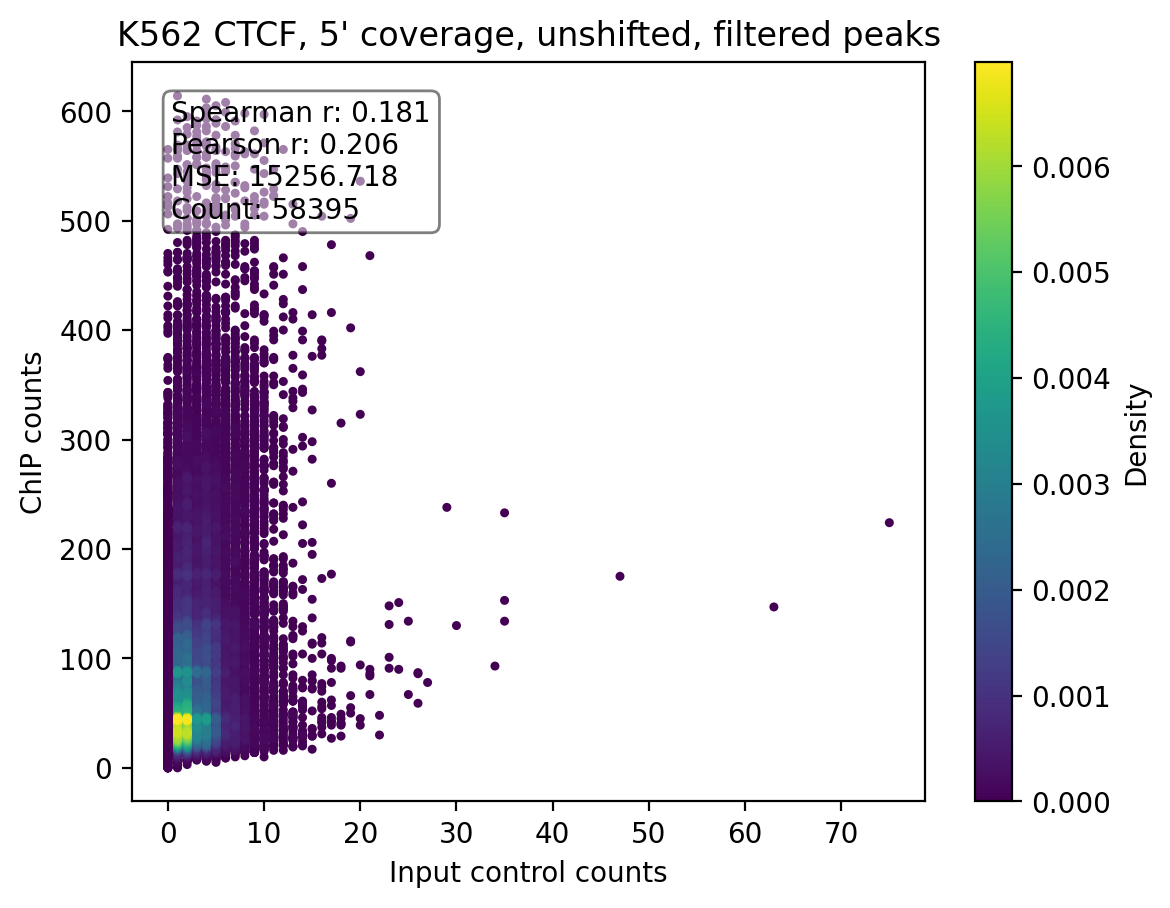

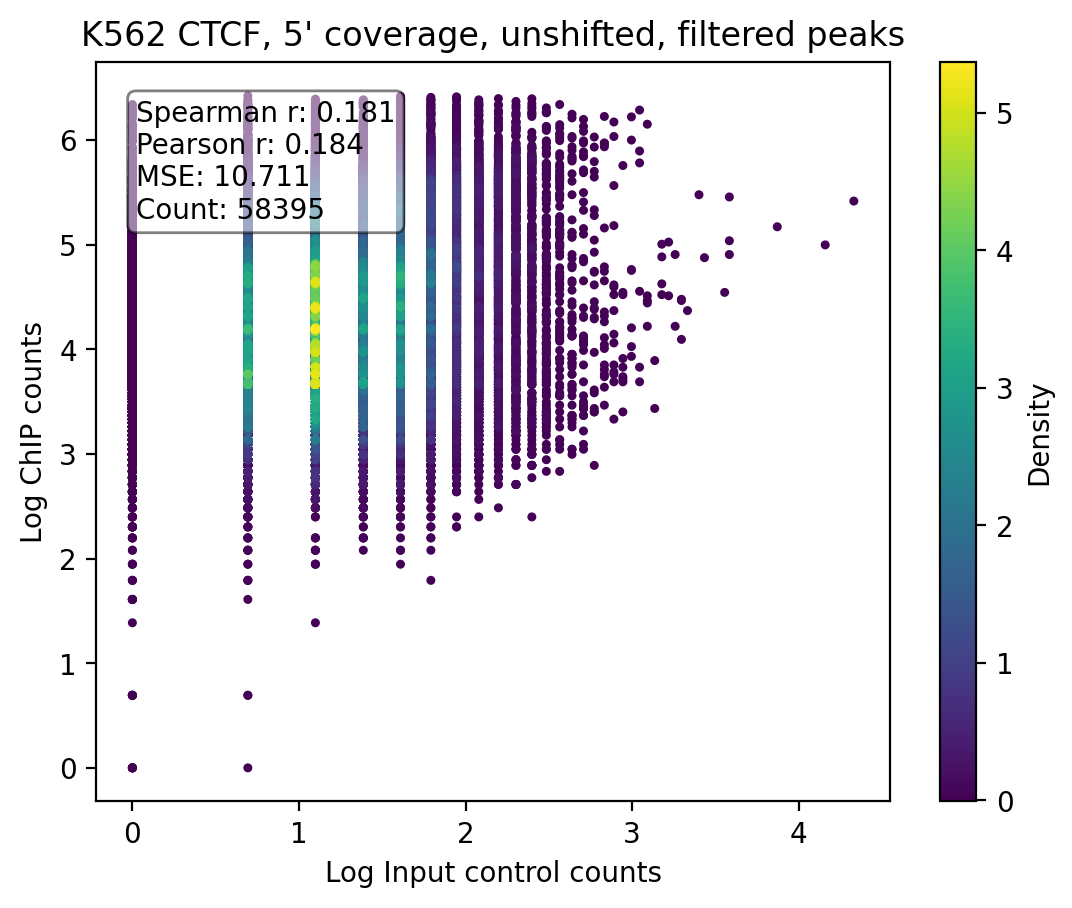

In [6]:
# plot chip_cts vs inputc_cts
density_scatter(inputc_cts, chip_cts, "Input control counts", "ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("K562 CTCF, 5' coverage, unshifted, filtered peaks")
plt.show()

# plot log chip_cts vs log inputc_cts
density_scatter(np.log1p(inputc_cts), np.log1p(chip_cts), "Log Input control counts", "Log ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("K562 CTCF, 5' coverage, unshifted, filtered peaks")
plt.show()

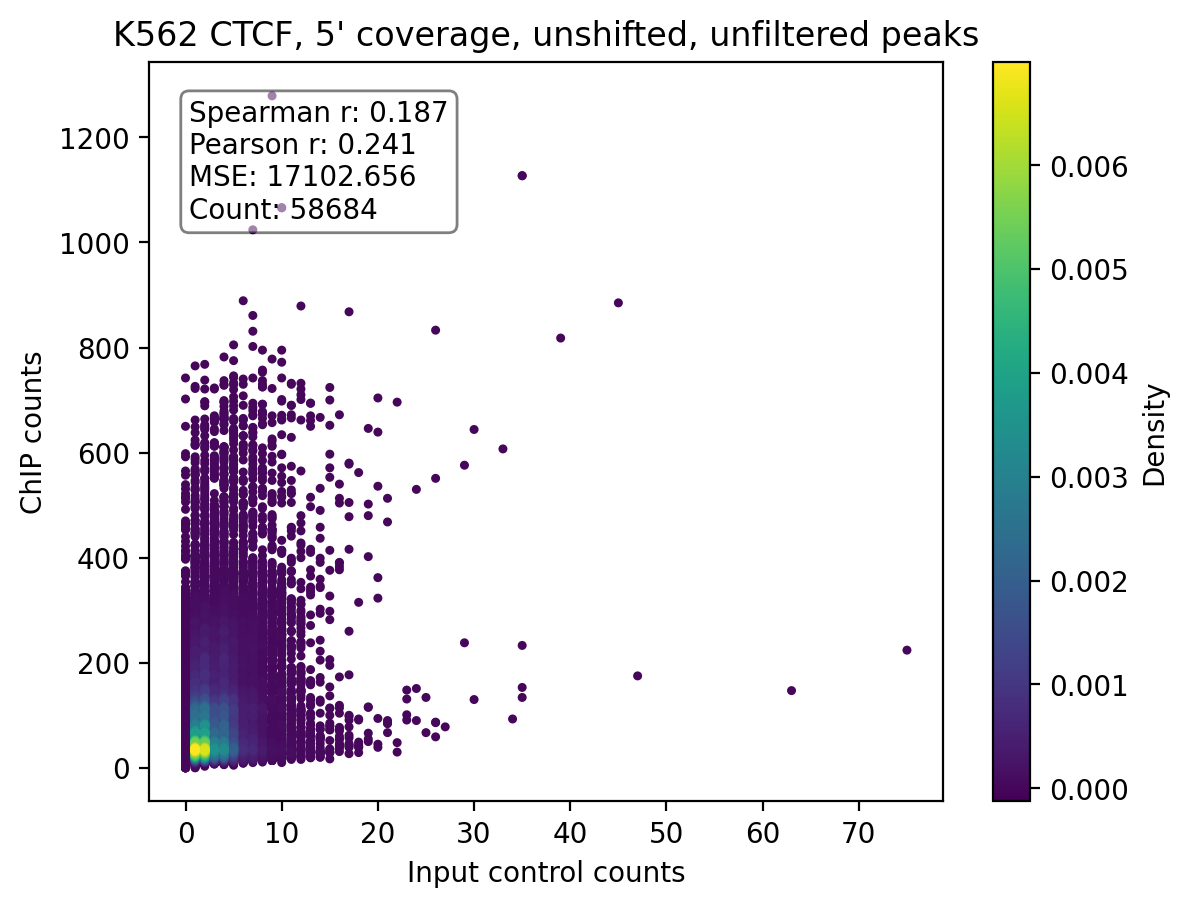

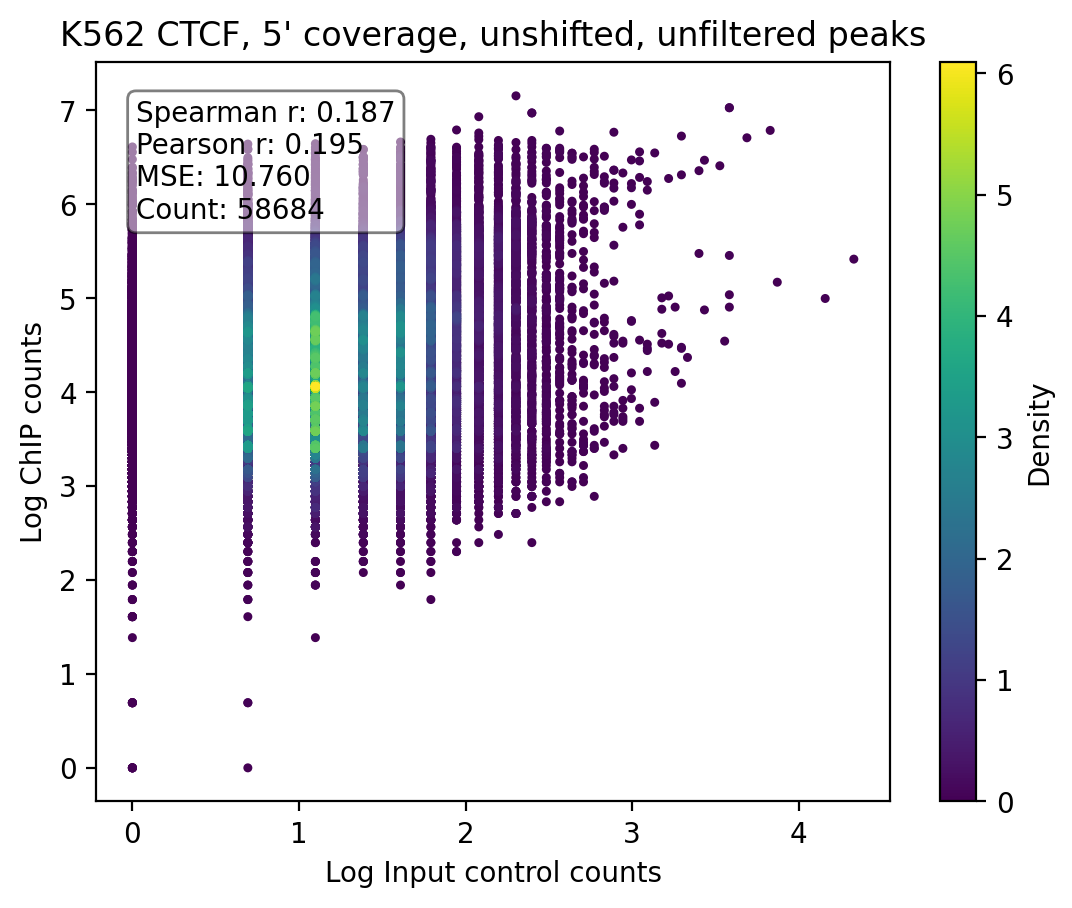

In [8]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/encode/k562_ctcf/ENCFF660GHM.bed"
chip_cts, inputc_cts = get_corre(p, inputc_minus, inputc_plus, chip_minus, chip_plus)

# plot chip_cts vs inputc_cts
density_scatter(inputc_cts, chip_cts, "Input control counts", "ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("K562 CTCF, 5' coverage, unshifted, unfiltered peaks")
plt.show()

# plot log chip_cts vs log inputc_cts
density_scatter(np.log1p(inputc_cts), np.log1p(chip_cts), "Log Input control counts", "Log ChIP counts", s=5, bins=200, incl_stats=True) 
plt.title("K562 CTCF, 5' coverage, unshifted, unfiltered peaks")
plt.show()

# Restore reverse_maya_gapped_peak_histone_closest_2114bp_atac ...

This got lost/overwritten after I moved some some stuff around 😡. So putting it back. Code taken from 12_21_2025.ipynb, 1_17_2026.ipynb, 1_18_2026.ipynb...

In [ ]:
base_dir = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble"

# read histone peaks (3-column BED assumed: chrom, start, end)
histone_bed = os.path.join(base_dir, "maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.sorted.lexicographic")
histone_df = pl.read_csv(
   histone_bed,
    separator="\t",
    has_header=False,
    new_columns=["chrom", "chromStart", "chromEnd"],
).select(["chrom", "chromStart", "chromEnd"])
assert len(histone_df.unique()) == len(histone_df)
print(histone_df.unique().shape, histone_df.shape)

# read chromosome sizes
chr_sizes = "/large_storage/goodarzilab/valehvpa/refs/hg38/hg38.chrom.sizes"
chr_sz_df = pl.read_csv(chr_sizes, separator="\t", has_header=False, new_columns=["chrom", "chrom_size"])

# add chromosome sizes to histone_df
histone_df = histone_df.join(
    chr_sz_df, left_on="chrom", right_on="chrom", how="left",
)
assert histone_df["chrom_size"].is_null().sum() == 0

# add length column
histone_df = histone_df.with_columns((pl.col("chromEnd") - pl.col("chromStart")).alias("length"))

histone_df = histone_df.to_pandas()

(45097, 3) (45097, 3)


In [ ]:
def run_closest_for_window_reverse(window: int, base_dir_override: str, atac_bed = None):
    print("*** Running for window size: ", window)

    # read atac peaks, keep only chrom, chromStart, chromEnd
    atac_df = pl.read_csv(
        atac_bed,
        separator="\t",
        has_header=False,
        new_columns=[
            "chrom", "chromStart", "chromEnd", "name", "score", "strand",
        ],
    ).select(["chrom", "chromStart", "chromEnd"])

    # select cols
    pl.from_pandas(histone_df).select(["chrom", "chromStart", "chromEnd"]).write_csv(
        os.path.join(base_dir_override,"temp_B.bed"),
        separator="\t",
        include_header=False
    )
    atac_df.select(["chrom", "chromStart", "chromEnd"]).write_csv(
        os.path.join(base_dir_override,"temp_A.bed"),
        separator="\t",
        include_header=False
    )

    # https://bedtools.readthedocs.io/en/latest/content/tools/closest.html
    fn_prefix = f"reverse_maya_gapped_peak_histone_closest_{str(window)}bp"
    # -t first returns the "first" closest feature in B in case of ties
    cmd = f"cd {base_dir_override} && \
        bedtools closest -a temp_A.bed -b temp_B.bed -t first > {fn_prefix}_atac.bed && \
        command rm -rf temp_A.bed && \
        command rm -rf temp_B.bed"
    os.system(cmd)

In [ ]:
bdo = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/gm12878_atac_encode/processed"
run_closest_for_window_reverse(
    2114,
    base_dir_override=bdo,
    atac_bed=os.path.join(bdo, "peaks.all_input_regions.ENCSR637XSC.summits.2114bp.sorted.lexicographic.bed.gz"),
)

*** Running for window size:  2114


In [ ]:
!head /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/gm12878_atac_encode/processed/reverse_maya_gapped_peak_histone_closest_2114bp_atac.bed

/bin/bash: /home/valehvpa/miniconda3/envs/hist6/lib/libtinfo.so.6: no version information available (required by /bin/bash)
chr1	8995	11109	chr1	777901	780141
chr1	777346	779460	chr1	777901	780141
chr1	777610	779724	chr1	777901	780141
chr1	777755	779869	chr1	777901	780141
chr1	778062	780176	chr1	777901	780141
chr1	803509	805623	chr1	804218	805669
chr1	803857	805971	chr1	804218	805669
chr1	804457	806571	chr1	804218	805669
chr1	825985	828099	chr1	826510	828466
chr1	826264	828378	chr1	826510	828466


The two counts below should be teh same (ie number of atac peaks is unchanged after bedtools closest)

In [ ]:
!zcat /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/gm12878_atac_encode/processed/peaks.all_input_regions.ENCSR637XSC.summits.2114bp.sorted.lexicographic.bed.gz | wc -l

/bin/bash: /home/valehvpa/miniconda3/envs/hist6/lib/libtinfo.so.6: no version information available (required by /bin/bash)
277907


In [ ]:
!wc -l /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/gm12878_atac_encode/processed/reverse_maya_gapped_peak_histone_closest_2114bp_atac.bed

/bin/bash: /home/valehvpa/miniconda3/envs/hist6/lib/libtinfo.so.6: no version information available (required by /bin/bash)
277907 /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/gm12878_atac_encode/processed/reverse_maya_gapped_peak_histone_closest_2114bp_atac.bed


In [ ]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/gm12878_atac_encode/processed/reverse_maya_gapped_peak_histone_closest_2114bp_atac.bed"
df = pd.read_csv(p, sep="\t", header=None, names=["chrom_atac", "start_atac", "end_atac", "chrom_histone", "start_histone", "end_histone"])
df

,chrom_atac,start_atac,end_atac,chrom_histone,start_histone,end_histone
0,chr1,8995,11109,chr1,777901,780141
1,chr1,777346,779460,chr1,777901,780141
2,chr1,777610,779724,chr1,777901,780141
3,chr1,777755,779869,chr1,777901,780141
4,chr1,778062,780176,chr1,777901,780141
...,...,...,...,...,...,...
277902,chrX,156012422,156014536,chrX,155997182,155998268
277903,chrX,156012694,156014808,chrX,155997182,155998268
277904,chrX,156015787,156017901,chrX,155997182,155998268
277905,chrY,4990899,4993013,.,-1,-1


In [ ]:
df[df["chrom_histone"] == "."]

,chrom_atac,start_atac,end_atac,chrom_histone,start_histone,end_histone
277905,chrY,4990899,4993013,.,-1,-1
277906,chrY,15354512,15356626,.,-1,-1


## constrain to 1k distance

skip the atac peaks who are not within Xbp of the hgp (in the sense coded below). Adn for those I set hist_chrom to -1 so that in the code after setting skip_missing_hist these will be effectively skipped.

In [ ]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/gm12878_atac_encode/processed/reverse_maya_gapped_peak_histone_closest_2114bp_atac.bed"
atac_hgp_df = pd.read_csv(p, sep="\t", header=None, names=[
    "chrom", "start", "end", "hist_chrom", "hist_start", "hist_end"
])

In [ ]:
# if end is < hist_start - 2000, or start > hist_end + 2000, then set out_of_bounds to True
X = 2000
atac_hgp_df["out_of_bounds"] = (atac_hgp_df["end"] < atac_hgp_df["hist_start"] - X) | (atac_hgp_df["start"] > atac_hgp_df["hist_end"] + X)
# if hist_chrom is ".", then also set out_of_bounds to True
atac_hgp_df.loc[atac_hgp_df["hist_chrom"] == ".", "out_of_bounds"] = True
atac_hgp_df["out_of_bounds"].sum() * 100 / len(atac_hgp_df)

45.3288330268759

In [ ]:
# if end is < hist_start - 1000, or start > hist_end + 1000, then set out_of_bounds to True
X = 1000
atac_hgp_df["out_of_bounds"] = (atac_hgp_df["end"] < atac_hgp_df["hist_start"] - X) | (atac_hgp_df["start"] > atac_hgp_df["hist_end"] + X)
# if hist_chrom is ".", then also set out_of_bounds to True
atac_hgp_df.loc[atac_hgp_df["hist_chrom"] == ".", "out_of_bounds"] = True
atac_hgp_df["out_of_bounds"].sum() * 100 / len(atac_hgp_df)

46.71023040081754

In [ ]:
idx = atac_hgp_df["out_of_bounds"] == True
atac_hgp_df.loc[idx, "hist_chrom"] = "."
atac_hgp_df.loc[idx, "hist_start"] = "-1"
atac_hgp_df.loc[idx, "hist_end"] = "-1"
# set dtype to int
atac_hgp_df["hist_start"] = atac_hgp_df["hist_start"].astype(int)
atac_hgp_df["hist_end"] = atac_hgp_df["hist_end"].astype(int)
del atac_hgp_df["out_of_bounds"]

/tmp/ipykernel_2582215/316362100.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  atac_hgp_df.loc[idx, "hist_start"] = "-1"
/tmp/ipykernel_2582215/316362100.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  atac_hgp_df.loc[idx, "hist_end"] = "-1"


In [ ]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/gm12878_atac_encode/processed/reverse_maya_gapped_peak_histone_closest_2114bp_atac_within_1k_bound.bed"
atac_hgp_df.to_csv(
    p,
    sep="\t",
    header=False,
    index=False
)

# Are chip counts correlated with peak length

I did this for control in 12_21_2025.ipynb

Answer is yes probalby, but how linearly?...

In [6]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/gm12878_atac_encode/processed/reverse_maya_gapped_peak_histone_closest_2114bp_atac.bed"
atac_hgp_df = pd.read_csv(p, sep="\t", header=None, names=[
    "chrom", "start", "end", "hist_chrom", "hist_start", "hist_end"
])

In [7]:
atac_hgp_df

,chrom,start,end,hist_chrom,hist_start,hist_end
0,chr1,8995,11109,chr1,777901,780141
1,chr1,777346,779460,chr1,777901,780141
2,chr1,777610,779724,chr1,777901,780141
3,chr1,777755,779869,chr1,777901,780141
4,chr1,778062,780176,chr1,777901,780141
...,...,...,...,...,...,...
277902,chrX,156012422,156014536,chrX,155997182,155998268
277903,chrX,156012694,156014808,chrX,155997182,155998268
277904,chrX,156015787,156017901,chrX,155997182,155998268
277905,chrY,4990899,4993013,.,-1,-1


In [8]:
def get_cts(
    peaks_df,
    bw,
    width: int,
    get_total_cts: bool = False,
):
    vals = []

    for _, r in peaks_df.iterrows():
        # w = r['length'] if width is None else width
        if width is not None:
            assert width % 2 == 0
            # take window of length width around center
            center = (r['hist_start'] + r['hist_end']) // 2
            start = center - (width // 2)
            end = center + (width // 2)
        else:
            start = r['hist_start']
            end = r['hist_end']
        if r["hist_chrom"] == ".":
            print("Skipping invalid histone chrom for region:", r)
            continue
        if not get_total_cts:
            vals.append(
                np.nan_to_num(bw.values(r['hist_chrom'],
                                        start,
                                        end))
            )
        else:
            vals.append(np.array([
                np.nansum(bw.values(r['hist_chrom'],
                                    start,
                                    end))
            ]))

    return vals

chip = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_coverage/GM12878/pileup/chip/all_reps.bw"
inputc = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_coverage/GM12878/pileup/inputc/inputc.bw"
import pyBigWig
chip_bw = pyBigWig.open(chip)
inputc_bw = pyBigWig.open(inputc)
    
chip_cts = get_cts(atac_hgp_df, chip_bw, width=None, get_total_cts=True)
chip_cts = [x[0] for x in chip_cts]  # flatten list of arrays

inputc_cts = get_cts(atac_hgp_df, inputc_bw, width=None, get_total_cts=True)
inputc_cts = [x[0] for x in inputc_cts]  # flatten list of arrays

Skipping invalid histone chrom for region: chrom            chrY
start         4990899
end           4993013
hist_chrom          .
hist_start         -1
hist_end           -1
Name: 277905, dtype: object
Skipping invalid histone chrom for region: chrom             chrY
start         15354512
end           15356626
hist_chrom           .
hist_start          -1
hist_end            -1
Name: 277906, dtype: object
Skipping invalid histone chrom for region: chrom            chrY
start         4990899
end           4993013
hist_chrom          .
hist_start         -1
hist_end           -1
Name: 277905, dtype: object
Skipping invalid histone chrom for region: chrom             chrY
start         15354512
end           15356626
hist_chrom           .
hist_start          -1
hist_end            -1
Name: 277906, dtype: object


In [9]:
atac_hgp_df = atac_hgp_df[atac_hgp_df["hist_chrom"] != "."]

In [10]:
atac_hgp_df["inputc_cts"] = inputc_cts
atac_hgp_df["chip_cts"] = chip_cts
atac_hgp_df["hist_length"] = atac_hgp_df["hist_end"] - atac_hgp_df["hist_start"]

/tmp/ipykernel_2602120/4259162216.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atac_hgp_df["inputc_cts"] = inputc_cts
/tmp/ipykernel_2602120/4259162216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atac_hgp_df["chip_cts"] = chip_cts
/tmp/ipykernel_2602120/4259162216.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

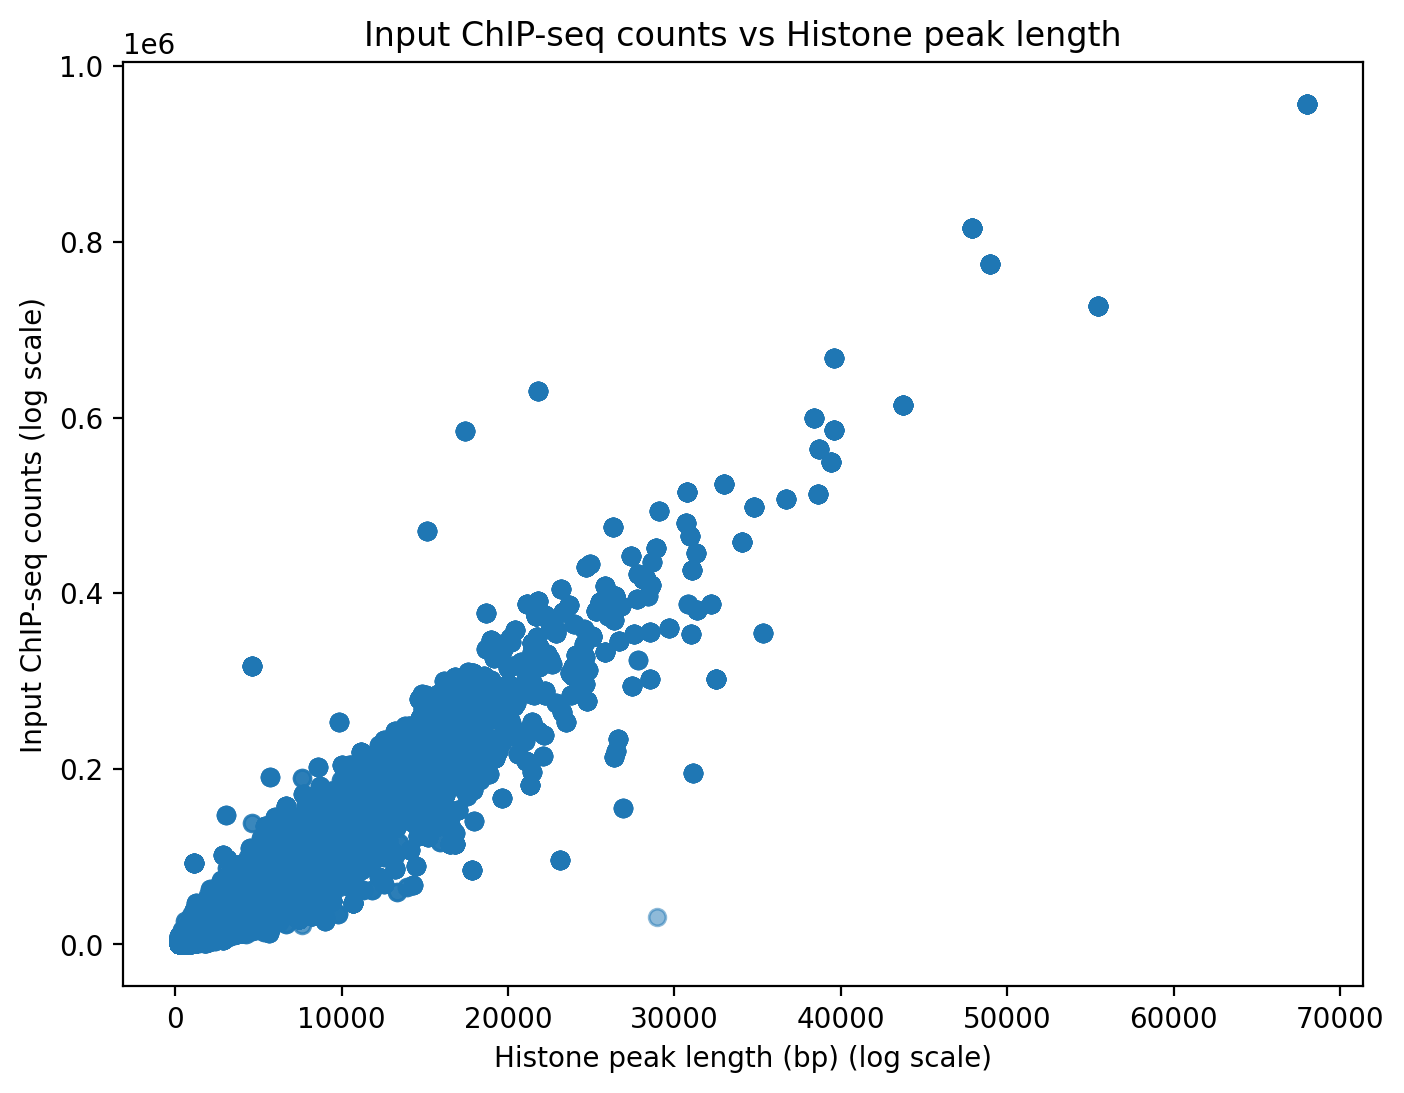

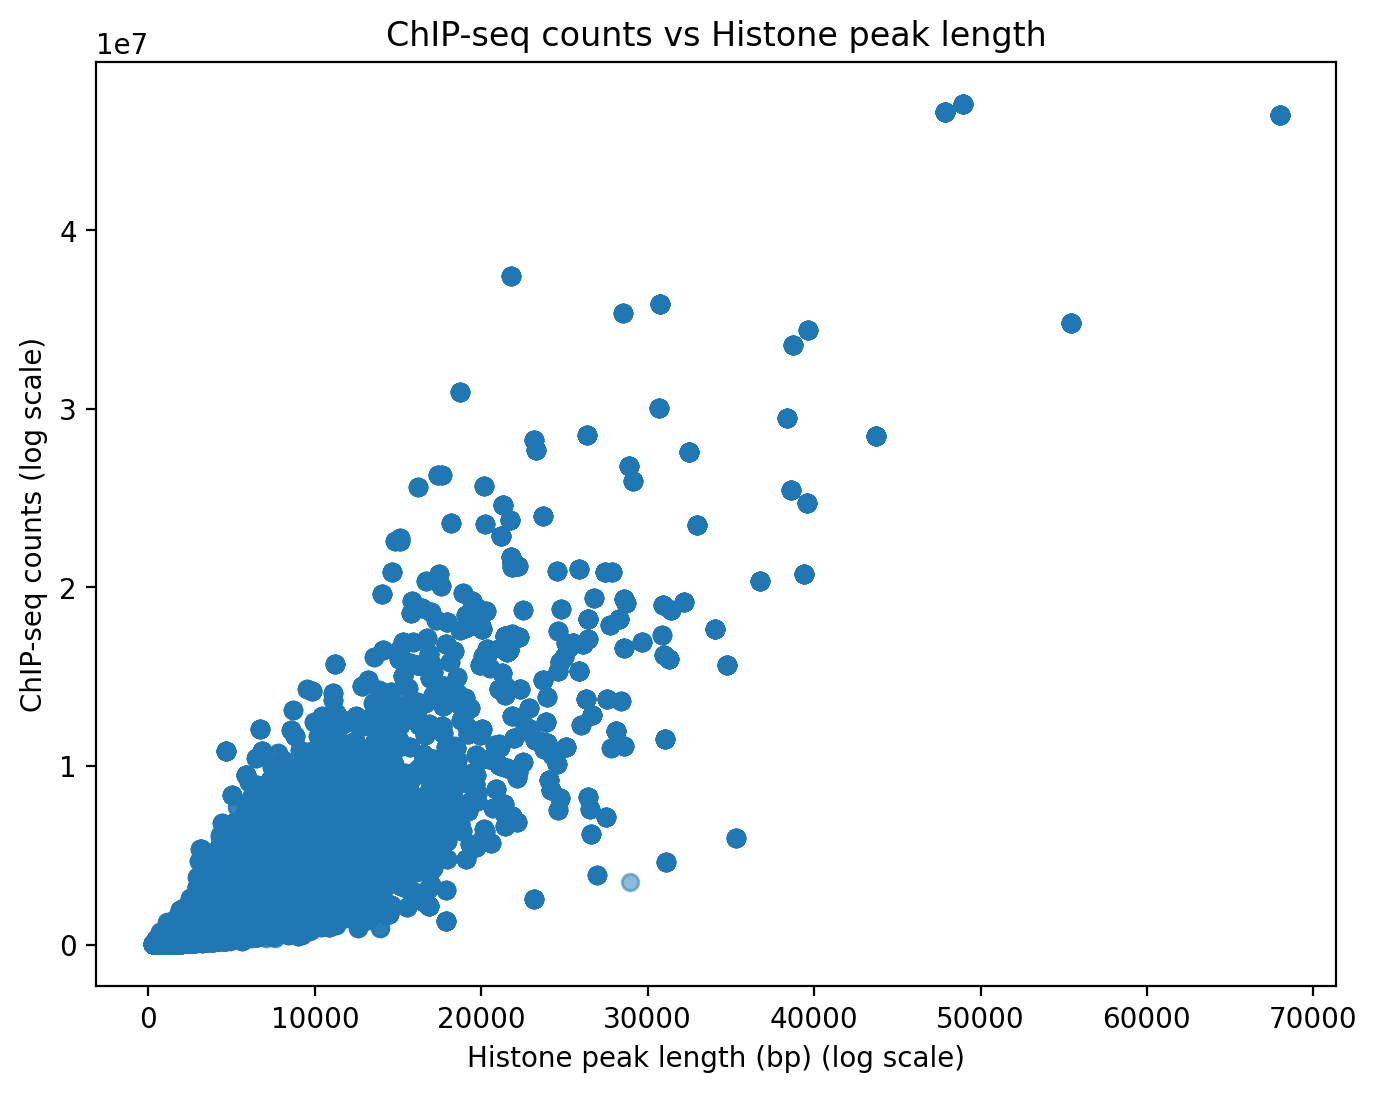

In [11]:
# inputc_cts as a function of length
plt.figure(figsize=(8,6))
plt.scatter(atac_hgp_df["hist_length"], atac_hgp_df["inputc_cts"], alpha=0.5)
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Histone peak length (bp) (log scale)")
plt.ylabel("Input ChIP-seq counts (log scale)")
plt.title("Input ChIP-seq counts vs Histone peak length")
plt.show()

# chip_cts as a function of length
plt.figure(figsize=(8,6))
plt.scatter(atac_hgp_df["hist_length"], atac_hgp_df["chip_cts"], alpha=0.5)
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Histone peak length (bp) (log scale)")
plt.ylabel("ChIP-seq counts (log scale)")
plt.title("ChIP-seq counts vs Histone peak length")
plt.show()

# hv3 test set performance barplot

Outlier window: 200 bp, Pearson correlation: 0.7072
Outlier window: 500 bp, Pearson correlation: 0.7457
Outlier window: 1k bp, Pearson correlation: 0.7669
Outlier window: 3k bp, Pearson correlation: 0.7591
Outlier window: 4k bp, Pearson correlation: 0.7490
Outlier window: 5k bp, Pearson correlation: 0.7604
Outlier window: 6k bp, Pearson correlation: 0.7622
Outlier window: 7k bp, Pearson correlation: 0.7425


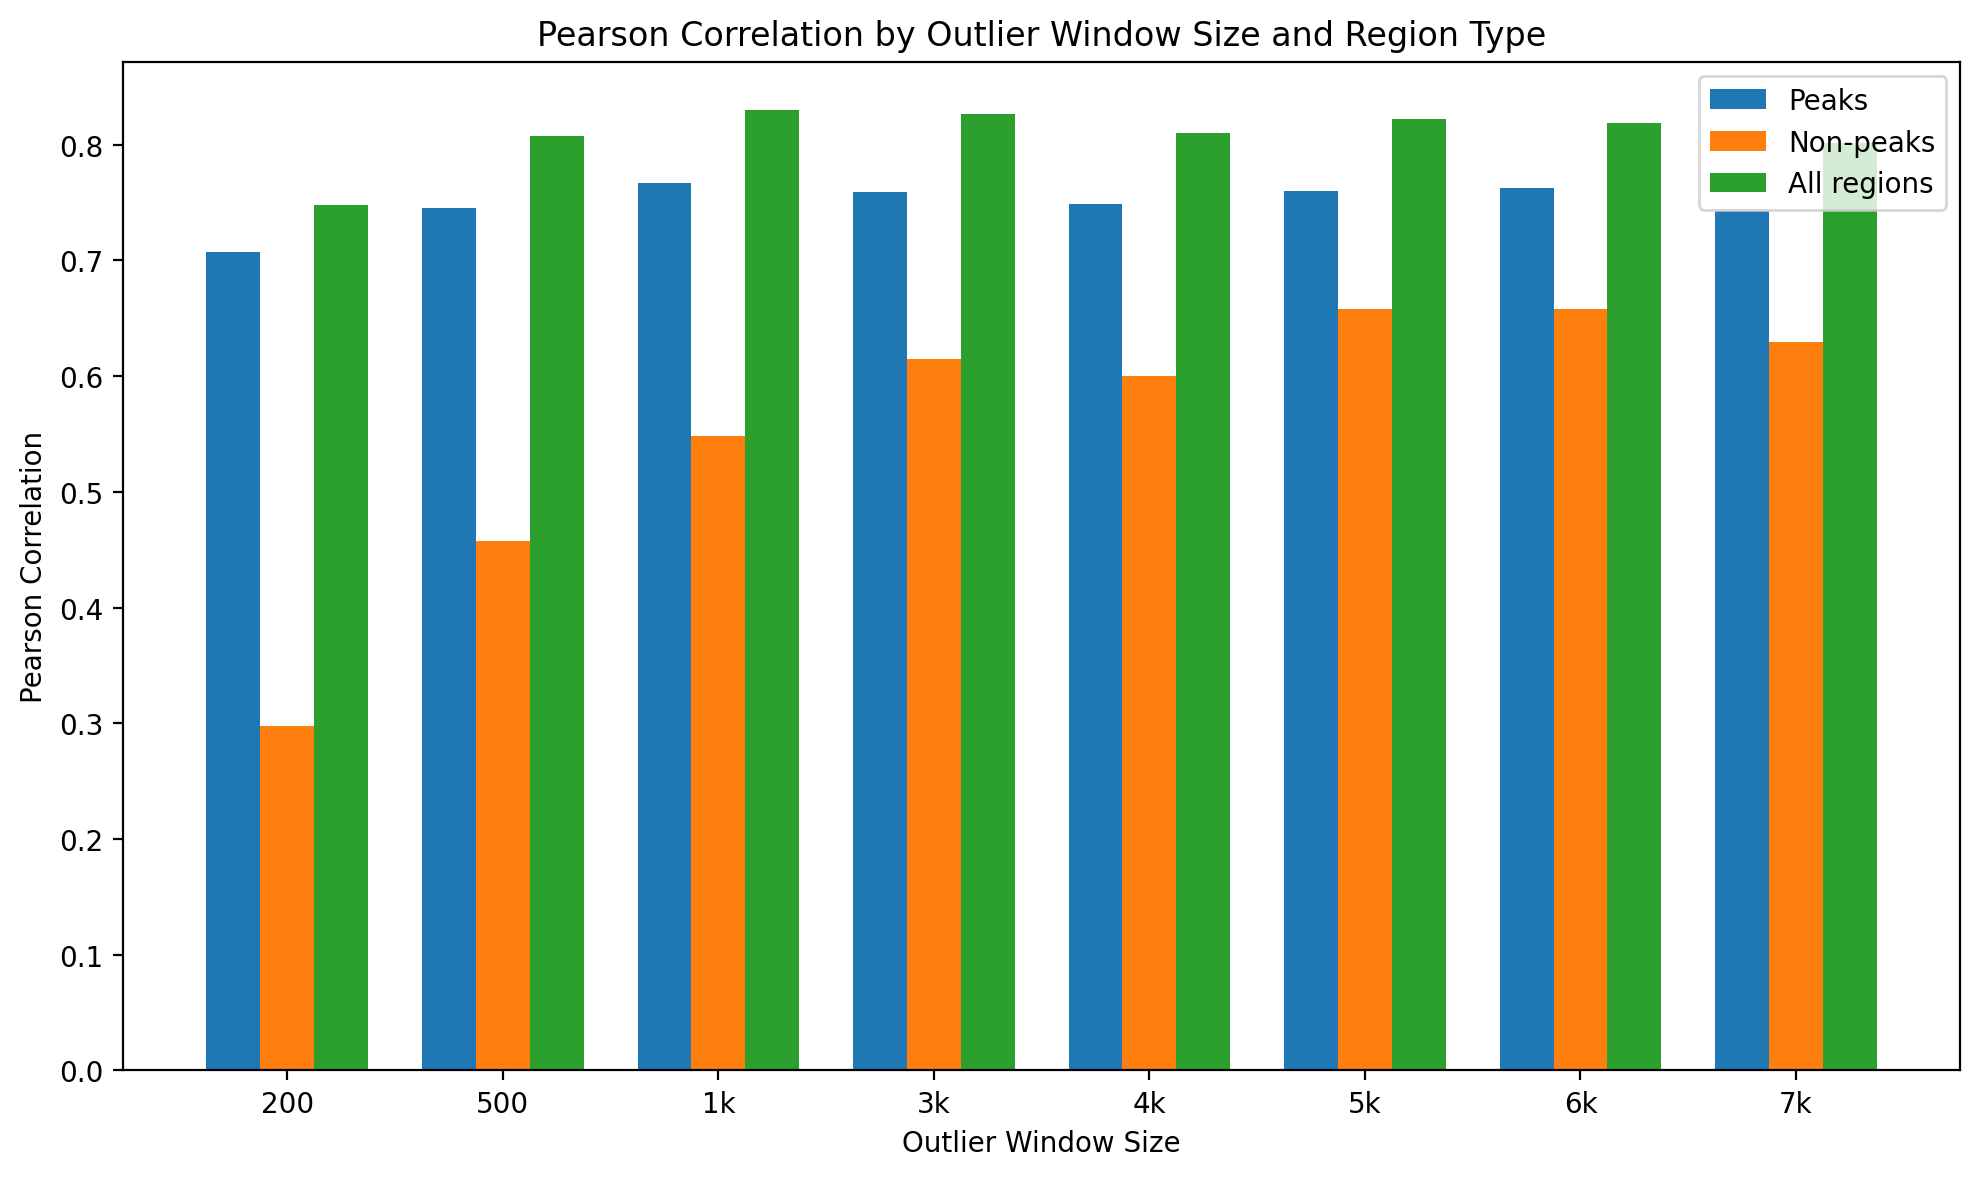

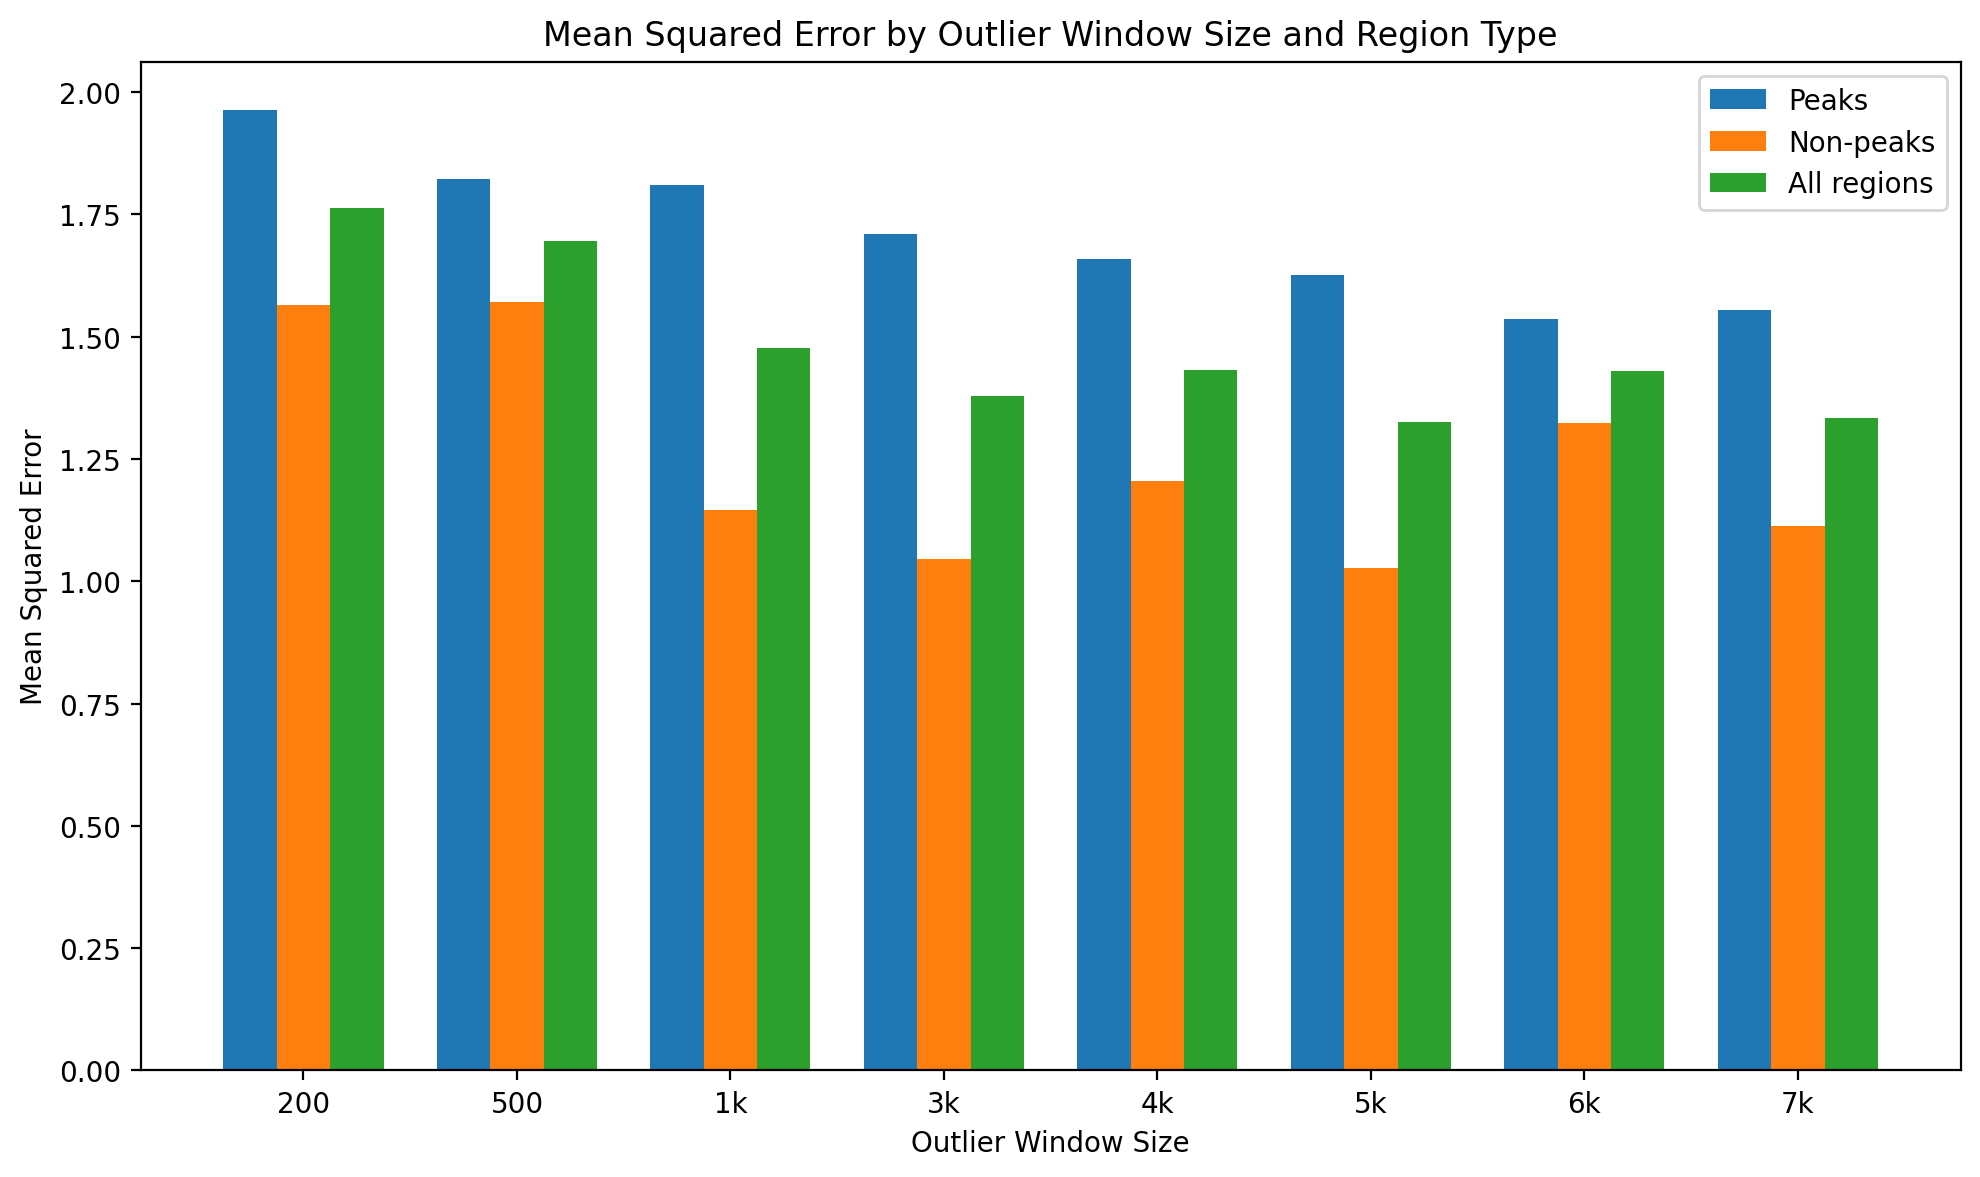

In [10]:
base_dir = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v3/train/instance-{}/predict/test/metrics_all_regions.json"

ow_to_inst = {
    "200": "20260121_145418",
    "500": "20260121_134441",
    "1k": "20260121_134835",
    "3k": "20260121_140126",
    "4k": "20260121_140241",
    "5k": "20260121_130457",
    "6k": "20260121_172641",
    "7k": "20260121_172811",
}

# {
#     "counts_metrics": {
#         "peaks_and_nonpeaks": {
#             "spearmanr": 0.7786023031429692,
#             "pearsonr": 0.8012603772710272,
#             "mse": 1.3326925039291382
#         },
#         "peaks": {
#             "spearmanr": 0.7476287164565747,
#             "pearsonr": 0.7424954732110193,
#             "mse": 1.553471565246582
#         },
#         "nonpeaks": {
#             "spearmanr": 0.5393108541640184,
#             "pearsonr": 0.6293466938189864,
#             "mse": 1.1119133234024048
#         }
#     }
# }

for ow, inst in ow_to_inst.items():
    p = base_dir.format(inst)
    import json
    d = json.load(open(p, "r"))
    print(f"Outlier window: {ow} bp, Pearson correlation: {d['counts_metrics']['peaks']['pearsonr']:.4f}")

# build a barploit with three different bars in each category: pearson in peaks, non peaks and all regions, and add bars for different outlier windows, sane for mse

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
data = []
for ow, inst in ow_to_inst.items():
    p = base_dir.format(inst)
    import json
    d = json.load(open(p, "r"))
    data.append({
        "outlier_window": ow,
        "pearson_peaks": d['counts_metrics']['peaks']['pearsonr'],
        "pearson_nonpeaks": d['counts_metrics']['nonpeaks']['pearsonr'],
        "pearson_all": d['counts_metrics']['peaks_and_nonpeaks']['pearsonr'],
    })
df = pd.DataFrame(data)
df = df.sort_values(by="outlier_window", key=lambda x: x.str.replace("k", "000").astype(int))
df

# plot
x = np.arange(len(df))  # the label locations
width = 0.25  # the width of the bars
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width, df['pearson_peaks'], width, label='Peaks')
rects2 = ax.bar(x, df['pearson_nonpeaks'], width, label='Non-peaks')
rects3 = ax.bar(x + width, df['pearson_all'], width, label='All regions')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pearson Correlation')
ax.set_xlabel('Outlier Window Size')
ax.set_title('Pearson Correlation by Outlier Window Size and Region Type')
ax.set_xticks(x)
ax.set_xticklabels(df['outlier_window'])
ax.legend()
fig.tight_layout()
plt.show()

# same for mse
data = []
for ow, inst in ow_to_inst.items():
    p = base_dir.format(inst)
    import json
    d = json.load(open(p, "r"))
    data.append({
        "outlier_window": ow,
        "mse_peaks": d['counts_metrics']['peaks']['mse'],
        "mse_nonpeaks": d['counts_metrics']['nonpeaks']['mse'],
        "mse_all": d['counts_metrics']['peaks_and_nonpeaks']['mse'],
    })
df = pd.DataFrame(data)
df = df.sort_values(by="outlier_window", key=lambda x: x.str.replace("k", "000").astype(int))
df

# plot
x = np.arange(len(df))  # the label locations
width = 0.25  # the width of the bars
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width, df['mse_peaks'], width, label='Peaks')
rects2 = ax.bar(x, df['mse_nonpeaks'], width, label='Non-peaks')
rects3 = ax.bar(x + width, df['mse_all'], width, label='All regions')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Outlier Window Size')
ax.set_title('Mean Squared Error by Outlier Window Size and Region Type')
ax.set_xticks(x)
ax.set_xticklabels(df['outlier_window'])
ax.legend()
fig.tight_layout()
plt.show()

## With lfc

first need to actually run everything in prediction mode again this time with the lfc eval

In [22]:
ow_to_inst = {
    "200": "20260121_145418",
    "500": "20260121_134441",
    "1k": "20260121_134835",
    "3k": "20260121_140126",
    "4k": "20260121_140241",
    "5k": "20260121_130457",
    "6k": "20260121_172641",
    "7k": "20260121_172811",
}

cmd = """python /home/valehvpa/projects/scCisTrans/histobpnet/scripts/train/main.py \\
    --command predict \\
    --name hv3.finetune.csf1_56.5p.ow{}.unweighted_ctrl.predict_lfc \\
    --model_type histobpnet_v3 \\
    --cvd 0 \\
    --output_dir /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v3/predict \\
    --checkpoint /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v3/train/instance-{}/pt_artifacts/best_model.ckpt \\
    --peaks /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/gm12878_atac_encode/ENCFF971WEQ/peaks.all_input_regions.ENCSR637XSC.bed.gz \\
    --negatives /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/gm12878_atac_encode/ENCFF971WEQ/fold_0/nonpeaks.all_input_regions.fold_0.ENCSR637XSC.bed.gz \\
    --bigwig /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_coverage/GM12878/5prime/chip/all_reps_shifted_5p_pooled.bw \\
    --bigwig_ctrl /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_coverage/GM12878/5prime/inputc/inputc_shifted_5p_pooled.bw \\
    --atac_hgp_map /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/gm12878_atac_encode/processed/reverse_narrow_peak_histone_closest_2114bp_atac_within_1k_bound.bed \\
    --ctrl_scaling_factor 1.56 \\
    --out_window {} \\
    --unweighted_ctrl"""

for ow, inst in ow_to_inst.items():
    ow_full = ow if "k" not in ow else str(int(ow.replace("k", "")) * 1000)
    print(cmd.format(ow, inst, ow_full))

python /home/valehvpa/projects/scCisTrans/histobpnet/scripts/train/main.py \
    --command predict \
    --name hv3.finetune.csf1_56.5p.ow200.unweighted_ctrl.predict_lfc \
    --model_type histobpnet_v3 \
    --cvd 0 \
    --output_dir /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v3/predict \
    --checkpoint /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v3/train/instance-20260121_145418/pt_artifacts/best_model.ckpt \
    --peaks /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/gm12878_atac_encode/ENCFF971WEQ/peaks.all_input_regions.ENCSR637XSC.bed.gz \
    --negatives /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/gm12878_atac_encode/ENCFF971WEQ/fold_0/nonpeaks.all_input_regions.fold_0.ENCSR637XSC.bed.gz \
    --bigwig /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_coverage/GM12878/5prime/chip/all_reps_shifted_5p_pooled.

Ok now read back the predictions now and make the barplot wiht lfc metrics

Output window: 200 bp, Pearson correlation: 0.4723
Output window: 500 bp, Pearson correlation: 0.4773
Output window: 1k bp, Pearson correlation: 0.4850
Output window: 3k bp, Pearson correlation: 0.4450
Output window: 4k bp, Pearson correlation: 0.4208
Output window: 5k bp, Pearson correlation: 0.4114
Output window: 6k bp, Pearson correlation: 0.4031
Output window: 7k bp, Pearson correlation: 0.3864


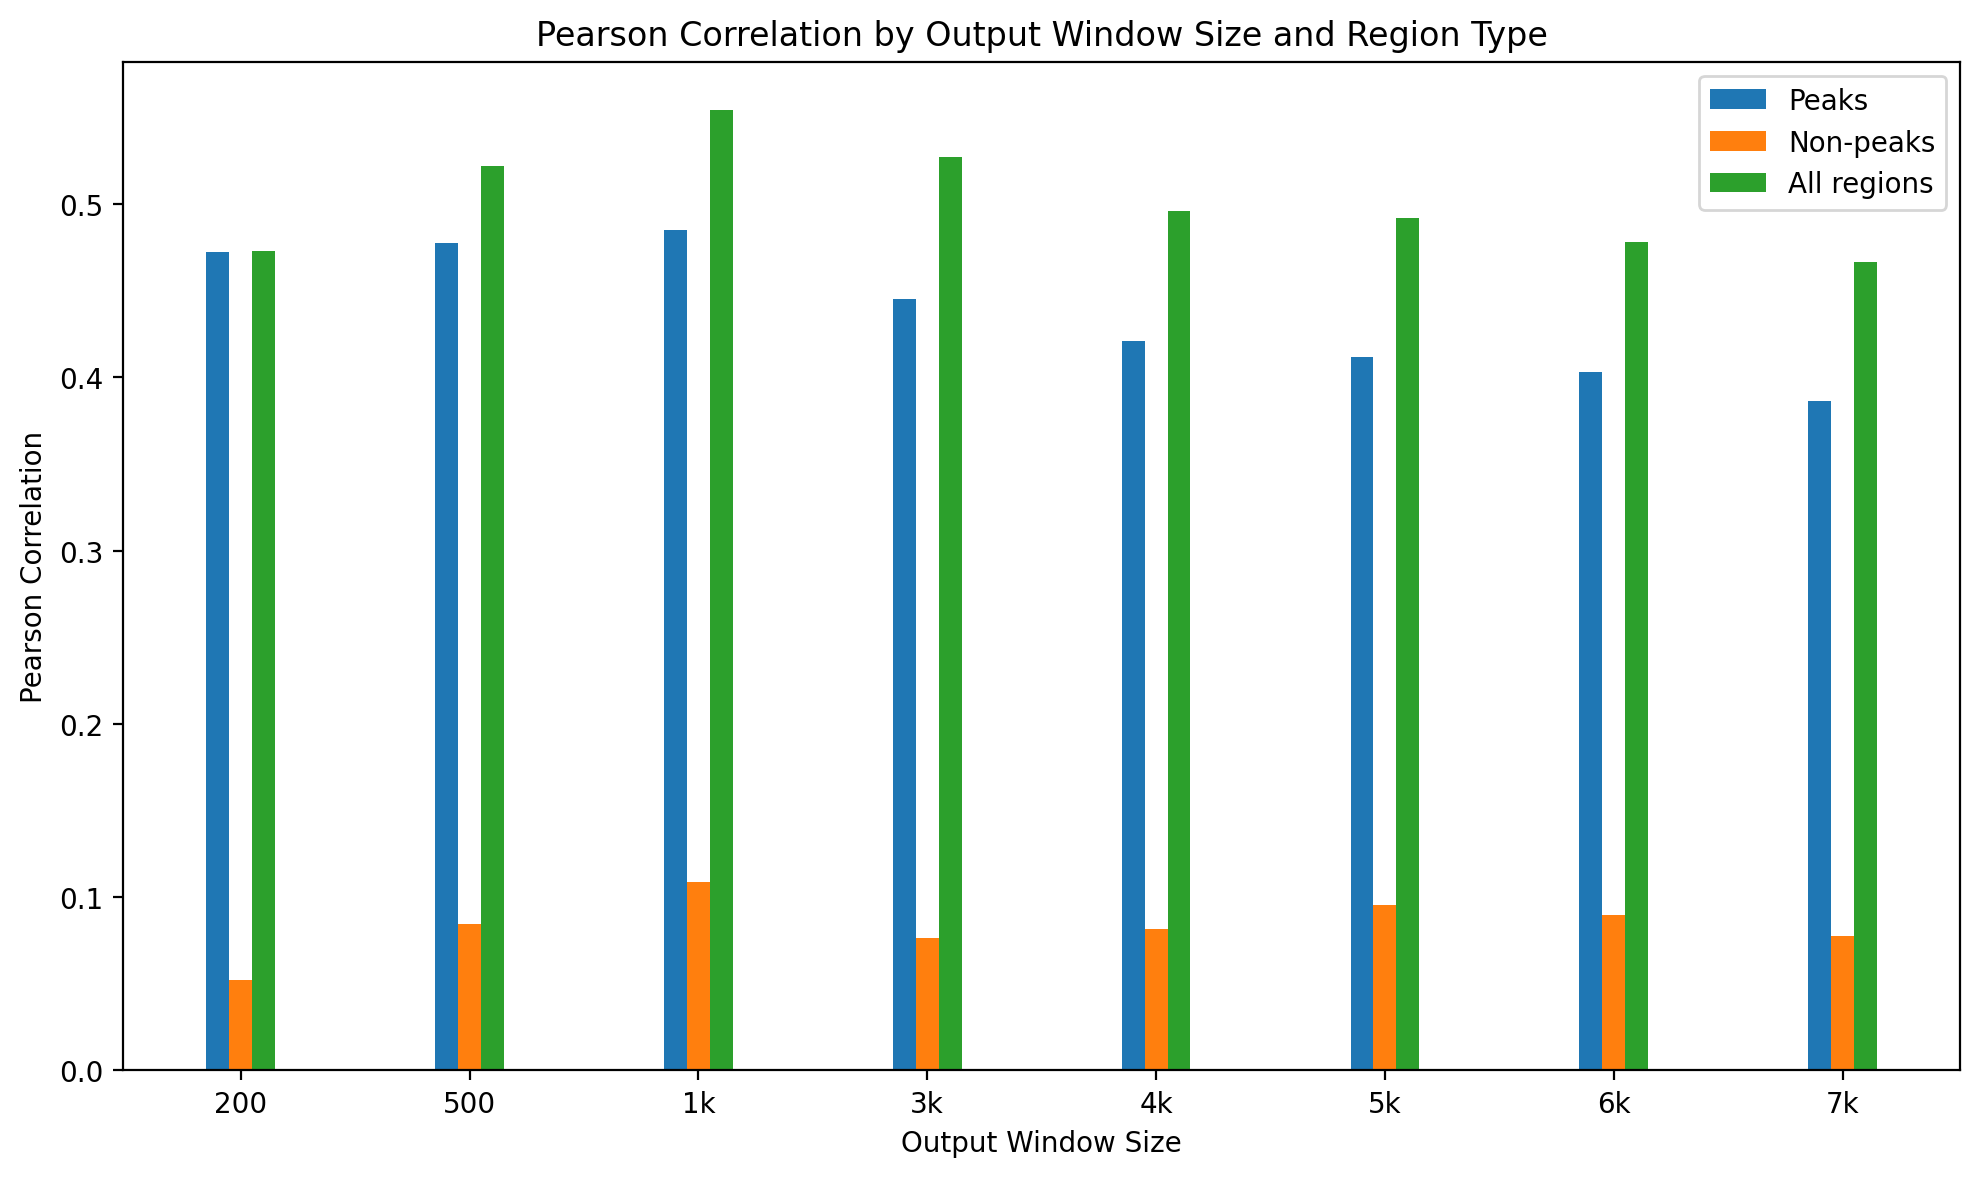

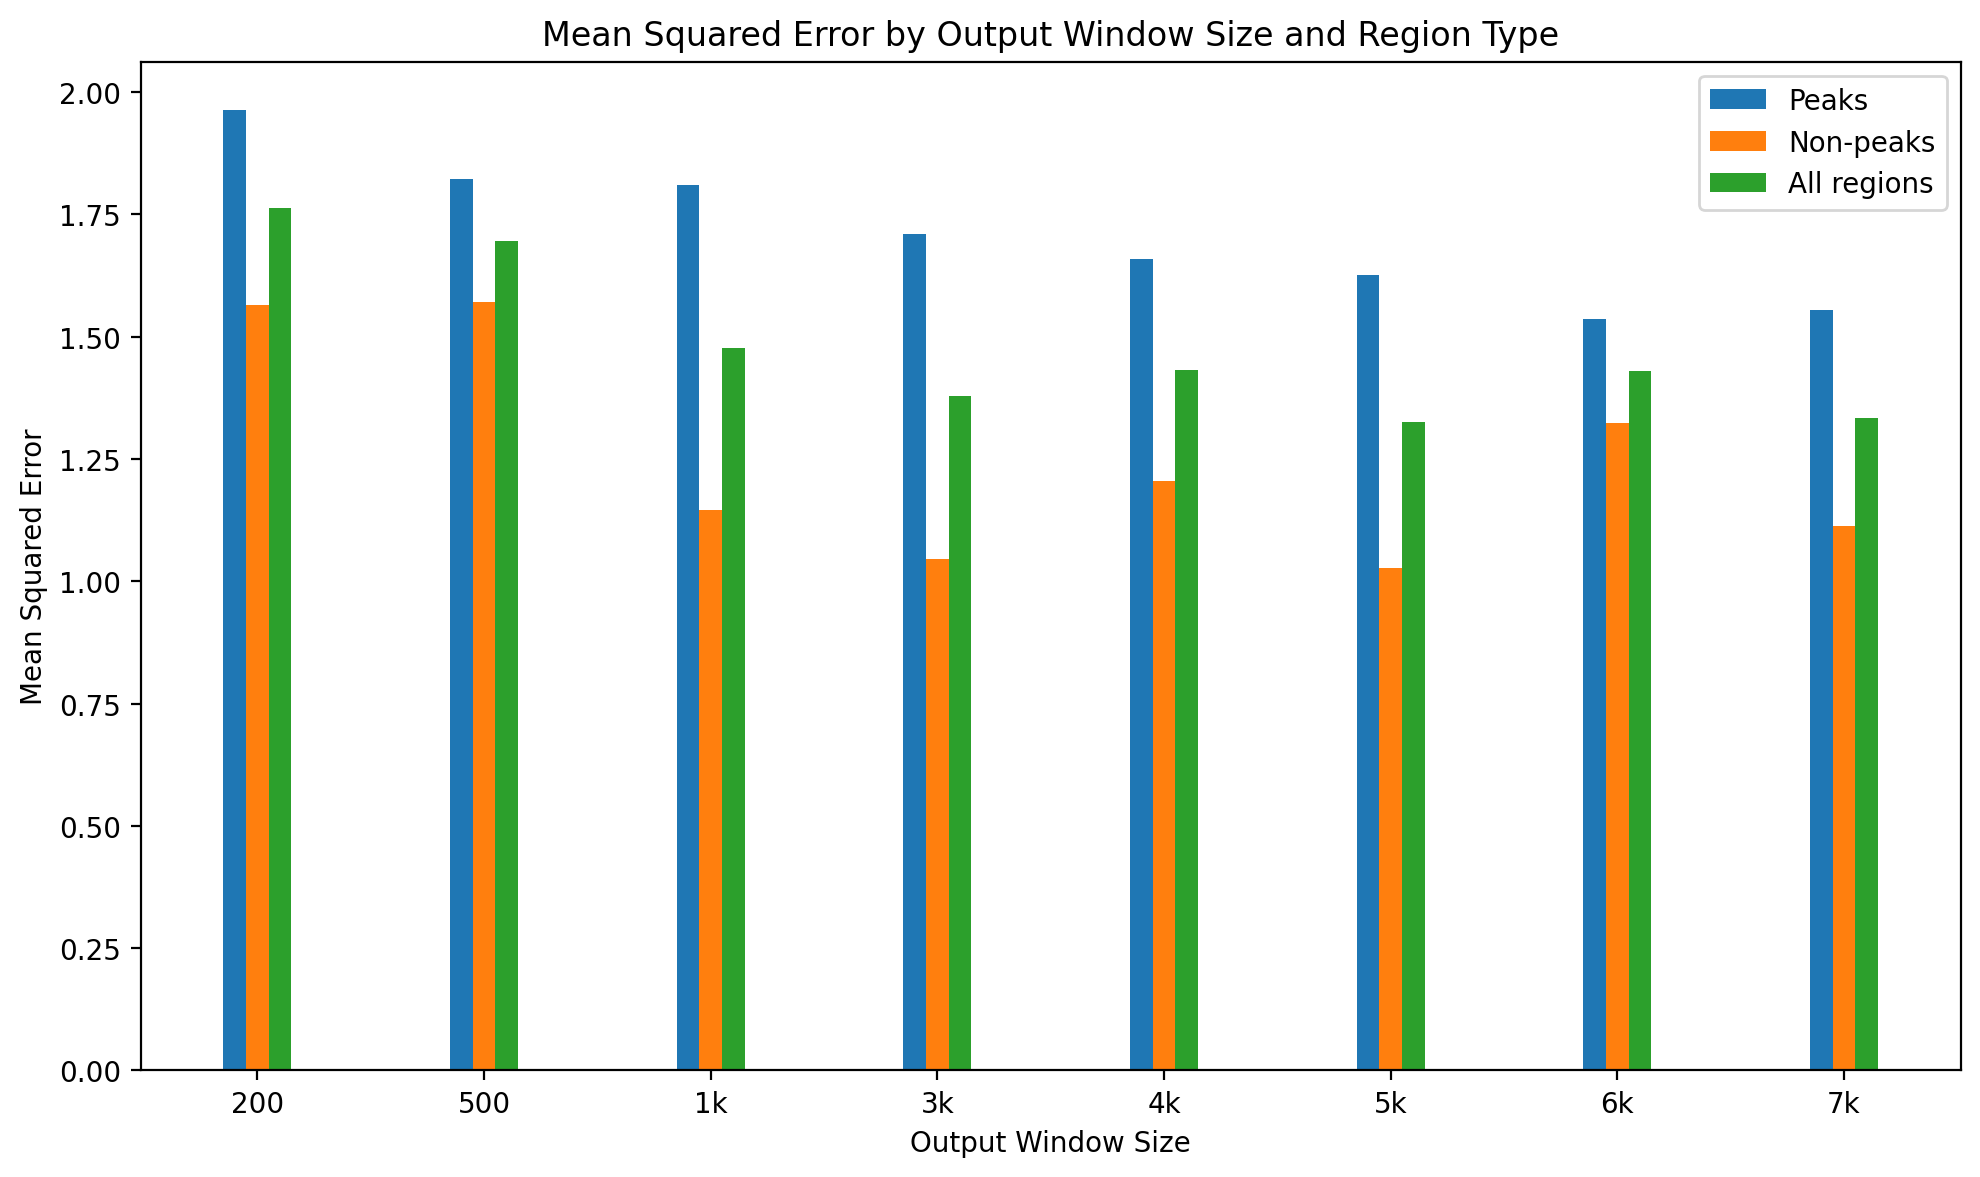

In [23]:
base_dir = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v3/predict/instance-{}/predict/test/metrics_all_regions.json"

ow_to_inst = {
    "200": "20260124_125802",
    "500": "20260124_125837",
    "1k": "20260121_182050",
    "3k": "20260124_125900",
    "4k": "20260124_130031",
    "5k": "20260124_130101",
    "6k": "20260124_130121",
    "7k": "20260124_130138",
}

# {
#     "counts_metrics": {
#         "peaks_and_nonpeaks": {
#             "spearmanr": 0.7786023031429692,
#             "pearsonr": 0.8012603772710272,
#             "mse": 1.3326925039291382
#         },
#         "peaks": {
#             "spearmanr": 0.7476287164565747,
#             "pearsonr": 0.7424954732110193,
#             "mse": 1.553471565246582
#         },
#         "nonpeaks": {
#             "spearmanr": 0.5393108541640184,
#             "pearsonr": 0.6293466938189864,
#             "mse": 1.1119133234024048
#         }
#     },
#     "lfc_metrics": {
#         "peaks_and_nonpeaks": {
#             "spearmanr": 0.42064668227081675,
#             "pearsonr": 0.4665427829652549,
#             "mse": 1.3326925039291382
#         },
#         "peaks": {
#             "spearmanr": 0.38711618245952273,
#             "pearsonr": 0.38636828667573925,
#             "mse": 1.553471565246582
#         },
#         "nonpeaks": {
#             "spearmanr": 0.0717520665905169,
#             "pearsonr": 0.07766142570914035,
#             "mse": 1.1119133234024048
#         }
#     }
# }

for ow, inst in ow_to_inst.items():
    p = base_dir.format(inst)
    import json
    d = json.load(open(p, "r"))
    print(f"Output window: {ow} bp, Pearson correlation: {d['lfc_metrics']['peaks']['pearsonr']:.4f}")

# build a barploit with three different bars in each category: pearson in peaks, non peaks and all regions, and add bars for different output windows, sane for mse

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
data = []
for ow, inst in ow_to_inst.items():
    p = base_dir.format(inst)
    import json
    d = json.load(open(p, "r"))
    data.append({
        "output_window": ow,
        "pearson_peaks": d['lfc_metrics']['peaks']['pearsonr'],
        "pearson_nonpeaks": d['lfc_metrics']['nonpeaks']['pearsonr'],
        "pearson_all": d['lfc_metrics']['peaks_and_nonpeaks']['pearsonr'],
    })
df = pd.DataFrame(data)
df = df.sort_values(by="output_window", key=lambda x: x.str.replace("k", "000").astype(int))
df

# plot
x = np.arange(len(df))  # the label locations
width = 0.1  # the width of the bars
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width, df['pearson_peaks'], width, label='Peaks')
rects2 = ax.bar(x, df['pearson_nonpeaks'], width, label='Non-peaks')
rects3 = ax.bar(x + width, df['pearson_all'], width, label='All regions')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pearson Correlation')
ax.set_xlabel('Output Window Size')
ax.set_title('Pearson Correlation by Output Window Size and Region Type')
ax.set_xticks(x)
ax.set_xticklabels(df['output_window'])
ax.legend()
fig.tight_layout()
plt.show()

# same for mse
data = []
for ow, inst in ow_to_inst.items():
    p = base_dir.format(inst)
    import json
    d = json.load(open(p, "r"))
    data.append({
        "output_window": ow,
        "mse_peaks": d['lfc_metrics']['peaks']['mse'],
        "mse_nonpeaks": d['lfc_metrics']['nonpeaks']['mse'],
        "mse_all": d['lfc_metrics']['peaks_and_nonpeaks']['mse'],
    })
df = pd.DataFrame(data)
df = df.sort_values(by="output_window", key=lambda x: x.str.replace("k", "000").astype(int))
df

# plot
x = np.arange(len(df))  # the label locations
width = 0.1  # the width of the bars
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width, df['mse_peaks'], width, label='Peaks')
rects2 = ax.bar(x, df['mse_nonpeaks'], width, label='Non-peaks')
rects3 = ax.bar(x + width, df['mse_all'], width, label='All regions')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Output Window Size')
ax.set_title('Mean Squared Error by Output Window Size and Region Type')
ax.set_xticks(x)
ax.set_xticklabels(df['output_window'])
ax.legend()
fig.tight_layout()
plt.show()

# "Same" LFC metric for borzoi

In [12]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/peak_scramble_py/temp_saved_7/df2_s.pkl"
pbedg = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/peak_scramble_py/temp_saved_7/orig_output_untransformed_sorted.bedgraph"

# read pkl
import pickle
df2_s = pickle.load(open(p, "rb"))
df2 = df2_s["20251103_121542"]
df2

# df2 contains extended histone gapped peak coordinates

chrom,start,end,atac_peak_count,mean_orig,mean_scrambled_atac,diff_atac,mean_scrambled_hist,diff_hist,mean_scrambled_all,diff_all,old_index
str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64
"""chr1""",776901,781141,4,0.225387,0.195147,0.7554438,0.197143,0.8253131,0.143505,0.229884,0
"""chr1""",803218,806669,3,0.2651457,0.2637988,0.9999556,0.263419,0.999908,0.143505,0.27613,1
"""chr1""",825510,829466,5,0.29787,0.226978,0.7600018,0.248294,0.8418437,0.143505,0.313661,2
"""chr1""",857164,859522,1,0.3680993,0.3626667,0.999248,0.366108,0.999615,0.143505,0.399087,3
"""chr1""",864369,867419,3,0.5330241,0.515501,0.9901029,0.513119,0.988478,0.143505,0.323573,4
…,…,…,…,…,…,…,…,…,…,…,…
"""chrX""",155229747,155232782,2,0.853947,0.835203,0.9964227,0.830874,0.9951445,0.143505,0.318437,45131
"""chrX""",155262233,155265483,6,0.7754777,0.664998,0.9536835,0.6460162,0.90834,0.143505,0.2972344,45132
"""chrX""",155330766,155336859,4,0.4817972,0.425606,0.956801,0.395378,0.9417717,0.143505,0.279106,45133


In [9]:
(df2["atac_peak_count"] == 0).sum()

0

for each extended histone gapped peak in df2, compute non-extedned start and end and then use the bedgraph file to get the binned fold change
signal for that region
then compute the geometric mean of the fold changes, this will be liek the average fold change for that histone peak (non extended)
then compute the log of that geometric mean fold change

In [14]:
# bgzip compress
!bgzip -c "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/peak_scramble_py/temp_saved_7/orig_output_untransformed_sorted.bedgraph" > "./temp_orig_output_untransformed_sorted.bedgraph.gz"

# tabix index as BED-like intervals
!tabix -p bed "./temp_orig_output_untransformed_sorted.bedgraph.gz"

/bin/bash: /home/valehvpa/miniconda3/envs/hist6/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/valehvpa/miniconda3/envs/hist6/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
import subprocess
import numpy as np

BGZ = "temp_orig_output_untransformed_sorted.bedgraph.gz"
BIN = 32

def fetch_vector(chrom: str, start: int, end: int) -> np.ndarray:
    region = f"{chrom}:{start}-{end}"

    cmd = f"""
    tabix {BGZ} {region} \
    | sort -k2,2n \
    | awk -v b={BIN} '
    BEGIN{{first=1; prev_e=-1}}
    {{
      s=$2; e=$3; v=$4

      # check bin width
      if ((e-s) != b) {{
        print "ERROR: non-32bp interval: " $0 > "/dev/stderr"
        exit 1
      }}

      # check contiguity
      if (!first && s != prev_e) {{
        print "ERROR: gap/overlap: prev_end=" prev_e " next_start=" s > "/dev/stderr"
        exit 1
      }}

      if (!first) printf "\\t"
      printf "%s", v

      first=0
      prev_e=e
    }}
    END{{ printf "\\n" }}'
    """

    out = subprocess.check_output(cmd, shell=True, text=True).strip()

    if not out:
        raise ValueError(f"No signal returned for region {region}")

    return np.array(out.split("\t"), dtype=float)

# def load_loci(path: str):
#     loci = []
#     with open(path) as f:
#         for line in f:
#             if not line.strip():
#                 continue
#             chrom, start, end = line.split()
#             loci.append((chrom, int(start), int(end)))
#     return loci

from toolbox.utils import nangeommean

vectors = {}
geom_mean_fc_s = {}
EXT = 1000
for chrom, start, end in df2[["chrom", "start", "end"]].iter_rows():
    hgp_start = start + EXT
    hgp_end = end - EXT
    vec = fetch_vector(chrom, hgp_start, hgp_end)
    peak_id = f"{chrom}:{start}-{end}"
    vectors[peak_id] = vec
    # assert vec.shape[0] * BIN == (hgp_end - hgp_start)
    # print(chrom, hgp_start, hgp_end, vec.shape)
    geom_mean_fc_s[peak_id] = nangeommean(vec)

In [ ]:
vectors["chr1:803218-806669"].shape

(46,)

In [6]:
803218+1000-(806669-1000)

-1451

In [26]:
46 * 32

1472

In [7]:
72 - 51


21

In [9]:
np.ceil(1451/32)

46.0

In [10]:
1451/32

45.34375

^ For loci such that end - start is not a multuiple of 32, the function fetch_xxx will return one value per 32bp bedGraph bin that overlaps your [start, end) interval. So if end - start isn’t a multiple of 32, you still get an integer number of bins (the bins that intersect the interval). The count might be sthg like np.ceil((end - start)/32). Anyway, the point is that you dont always have vec.shape[0] * BIN == (hgp_end - hgp_start)...

In [14]:
geom_mean_fc_s

{'chr1:776901-781141': array(0.83482966),
 'chr1:803218-806669': array(0.03171472),
 'chr1:825510-829466': array(0.38514807),
 'chr1:857164-859522': array(0.23441415),
 'chr1:864369-867419': array(0.90288283),
 'chr1:957520-962162': array(3.44590613),
 'chr1:965428-967937': array(6.66798327),
 'chr1:991274-994144': array(0.54215471),
 'chr1:1010987-1016208': array(3.7569779),
 'chr1:1018425-1021729': array(1.34590205),
 'chr1:1030464-1032892': array(2.31560489),
 'chr1:1037487-1040604': array(1.87005329),
 'chr1:1061958-1065905': array(6.48057378),
 'chr1:1114716-1117074': array(4.082252),
 'chr1:1136108-1139210': array(1.47325508),
 'chr1:1142994-1146026': array(3.46475972),
 'chr1:1156515-1159943': array(4.06763771),
 'chr1:1199733-1202451': array(1.20364425),
 'chr1:1211598-1216885': array(4.85837887),
 'chr1:1229246-1233924': array(3.88905614),
 'chr1:1248760-1252761': array(1.14514677),
 'chr1:1271908-1275559': array(7.66631855),
 'chr1:1303901-1310378': array(3.71367241),
 'chr1:

In [ ]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/peak_scramble_py/temp_saved_7/geom_mean_fc_s.pkl"
pickle.dump(geom_mean_fc_s, open(p, "wb"))

In [16]:
# read pickle
import pickle
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/peak_scramble_py/temp_saved_7/geom_mean_fc_s.pkl"
fff = pickle.load(open(p, "rb"))
fff

{'chr1:776901-781141': array(0.83482966),
 'chr1:803218-806669': array(0.03171472),
 'chr1:825510-829466': array(0.38514807),
 'chr1:857164-859522': array(0.23441415),
 'chr1:864369-867419': array(0.90288283),
 'chr1:957520-962162': array(3.44590613),
 'chr1:965428-967937': array(6.66798327),
 'chr1:991274-994144': array(0.54215471),
 'chr1:1010987-1016208': array(3.7569779),
 'chr1:1018425-1021729': array(1.34590205),
 'chr1:1030464-1032892': array(2.31560489),
 'chr1:1037487-1040604': array(1.87005329),
 'chr1:1061958-1065905': array(6.48057378),
 'chr1:1114716-1117074': array(4.082252),
 'chr1:1136108-1139210': array(1.47325508),
 'chr1:1142994-1146026': array(3.46475972),
 'chr1:1156515-1159943': array(4.06763771),
 'chr1:1199733-1202451': array(1.20364425),
 'chr1:1211598-1216885': array(4.85837887),
 'chr1:1229246-1233924': array(3.88905614),
 'chr1:1248760-1252761': array(1.14514677),
 'chr1:1271908-1275559': array(7.66631855),
 'chr1:1303901-1310378': array(3.71367241),
 'chr1:

In [24]:
!command rm -rf /home/valehvpa/projects/scCisTrans/histobpnet/experiments/valeh/notebooks/temp_orig_output_untransformed_sorted.bedgraph.gz
!command rm -rf /home/valehvpa/projects/scCisTrans/histobpnet/experiments/valeh/notebooks/temp_orig_output_untransformed_sorted.bedgraph.gz.tbi

/bin/bash: /home/valehvpa/miniconda3/envs/hist6/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/valehvpa/miniconda3/envs/hist6/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# sanity checking something


I want to look at the correlation between log1p(scaled control) and log1p(chip) in non-histone-peak regions. See my slide deck circa slide 268 where I talk about interpreting the results (in non peak regions) of KO-ing seqeunce un my hv2 model...

code below from 12_3_2025.ipynb

In [6]:
base_dir = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble"
excluded_1kb = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.excluded.1000bp"
peaks = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.sorted"

# excluded_1kb contains ~5k 1kb length regions of the genome that dont intersect with the peaks (ie non-peak regions)
df_1kb = pd.read_csv(excluded_1kb, sep="\t", header=None)
df_1kb.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)

# Remove invalid chrombooses. My peaks file actually contains all valid chromosoms, let s just use that.
peaks_df = pd.read_csv(peaks, sep="\t", header=None)
peaks_df.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)
valid_chroms = peaks_df["chrom"].unique().tolist()
df_1kb = df_1kb[df_1kb["chrom"].isin(valid_chroms)]

In [26]:
df_1kb

,chrom,start,end,3,4,5
0,chr14,32214747,32215747,1,1000,-
1,chr4,5735302,5736302,2,1000,-
2,chr17,77056862,77057862,3,1000,+
3,chr15,53809817,53810817,4,1000,+
4,chr10,4285605,4286605,5,1000,+
...,...,...,...,...,...,...
4995,chr4,132710403,132711403,5246,1000,-
4996,chr19,18392198,18393198,5247,1000,-
4997,chr1,142213808,142214808,5248,1000,+
4998,chr10,30072198,30073198,5249,1000,+


In [28]:
32214747-32215747, 5735302-5736302, 19209174-19210174

(-1000, -1000, -1000)

code below form 1_10_2026.ipynb

In [7]:
p = peaks
# these are the bigwigs I used to train instance-20260124_133620 (which is the pre trained model I then used to ablate sequence)
chip = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_coverage/GM12878/5prime/chip/all_reps_shifted_5p_pooled.bw"
inputc = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_coverage/GM12878/5prime/inputc/inputc_shifted_5p_pooled.bw"

import pyBigWig
chip_bw = pyBigWig.open(chip)
inputc_bw = pyBigWig.open(inputc)
def get_cts(
    peaks_df,
    bw,
    width,
    get_total_cts: bool = False,
    scaling_factor: float = 1.0,
):
    vals = []

    for _, r in peaks_df.iterrows():
        # w = r['length'] if width is None else width
        if not get_total_cts:
            assert scaling_factor == 1.0
            vals.append(
                np.nan_to_num(bw.values(r['chrom'],
                                        r['start'],
                                        r['end']))
            )
        else:
            vals.append(np.array([
                scaling_factor * np.nansum(bw.values(r['chrom'],
                                                    r['start'],
                                                    r['end']))
            ]))

    return vals

In [9]:
csf = 1.0
chip_cts = get_cts(df_1kb, chip_bw, None, get_total_cts=True)
inputc_cts = get_cts(df_1kb, inputc_bw, None, get_total_cts=True, scaling_factor=csf)

chip_cts = np.array([v[0] for v in chip_cts]).squeeze()
inputc_cts = np.array([v[0] for v in inputc_cts]).squeeze()

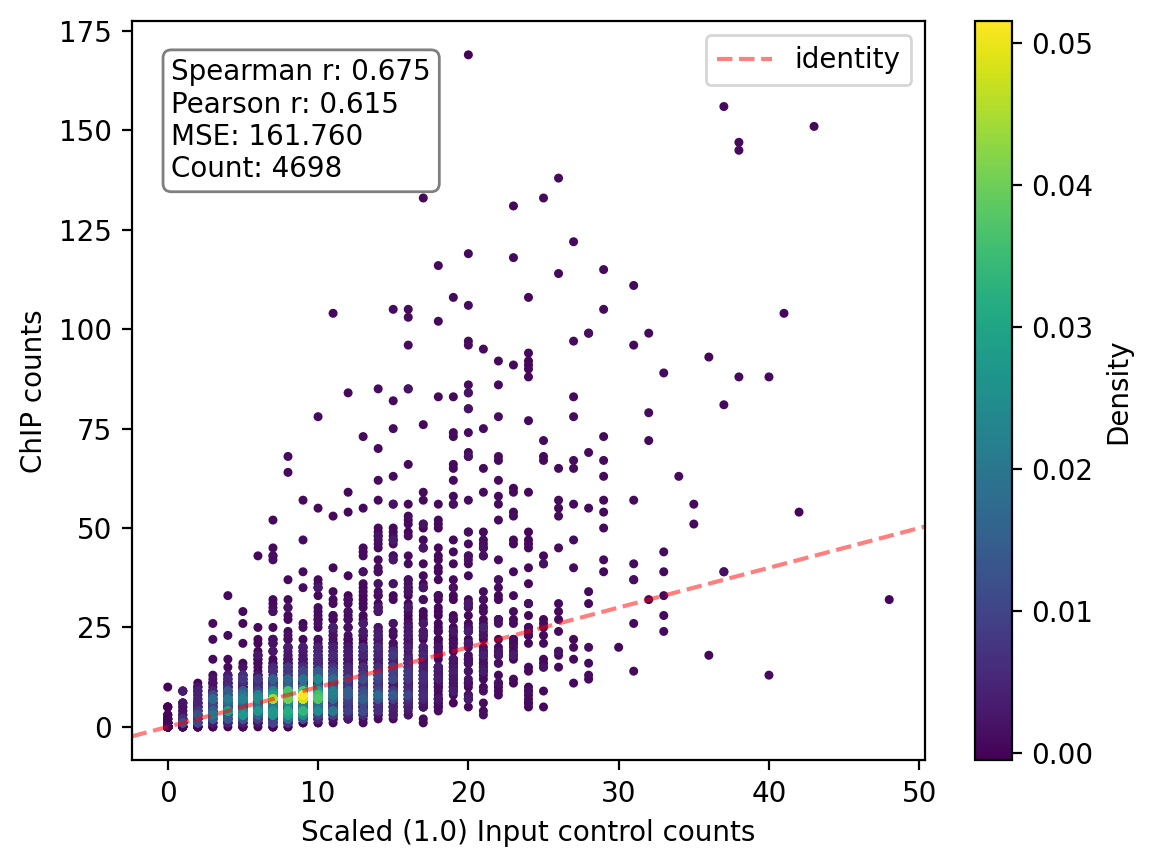

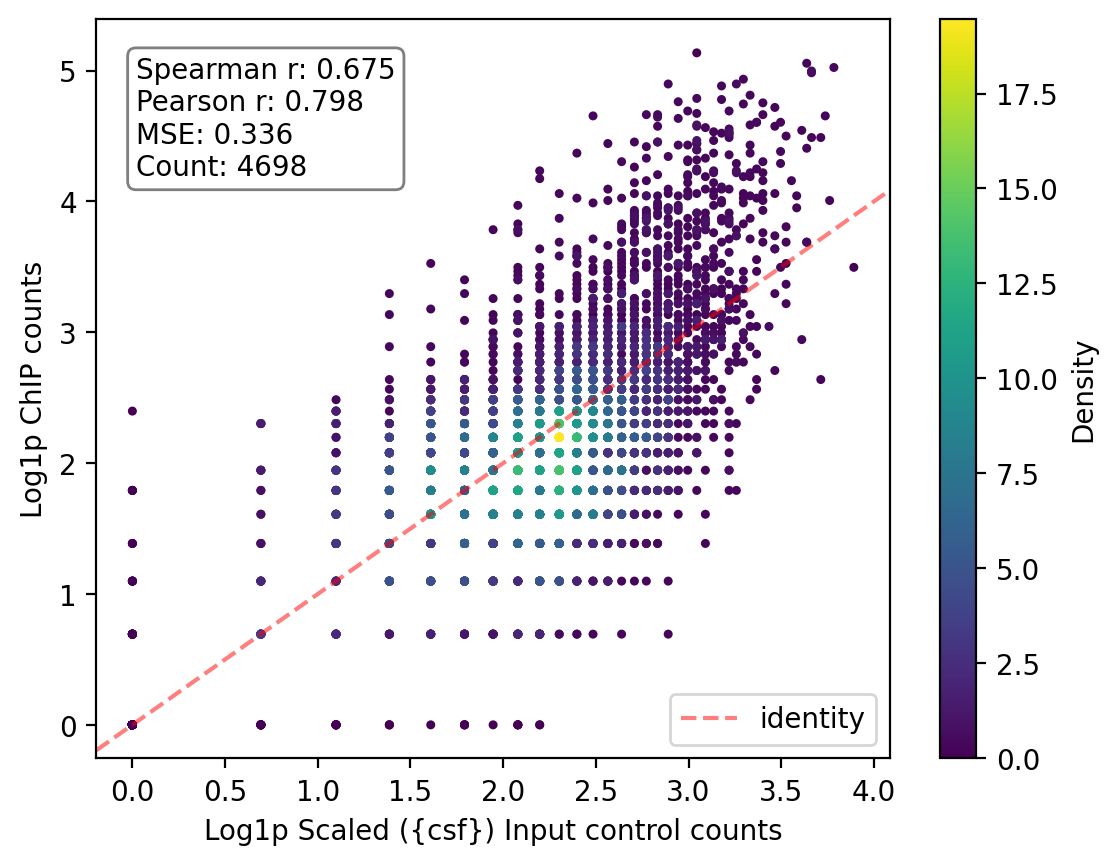

In [37]:
# plot chip_cts vs inputc_cts
density_scatter(inputc_cts, chip_cts, f"Scaled ({csf}) Input control counts", "ChIP counts", s=5, bins=200, incl_stats=True) 
ax = plt.gca()
from toolbox.plt_utils import add_identity
add_identity(ax, color="r", ls="--", alpha=0.5)
plt.show()

# plot log chip_cts vs log inputc_cts
density_scatter(np.log1p(inputc_cts), np.log1p(chip_cts), "Log1p Scaled ({csf}) Input control counts", "Log1p ChIP counts", s=5, bins=200, incl_stats=True) 
ax = plt.gca()
from toolbox.plt_utils import add_identity
add_identity(ax, color="r", ls="--", alpha=0.5)
plt.show()

See "ChIP vs Control Sum in 1000bp Background Regions (bed-based) with Regression Line" here: 
https://github.com/kundajelab/histobpnet/blob/main/experiments/valeh/notebooks/12_3_2025.ipynb

I expect the range of the control (and in fact also chip) in my first plot above to be about the same, or LOWER, than the ones in the plot in the notebok linked above. Why? because in that notebook I count the number of fragments that overlap the non-peak locus of interest (which I m looking exaclty at the same non-peak loci here btw so that s exactly the same), while here I count the same BUT I count a fragment if its shifted 5' end lies within the non-peak locus of interest. Since the shifted 5' end of a fragment is a single base pair, while the fragment itself is longer (eg 200bp), counting fragments that overlap a locus will generally count more fragments than counting fragments whose shifted 5' end lies within the locus. Thus I expect the counts here (say for a given locus) to be lower than or equal to those in the notebook linked above. (I didnt mathematically double check this but visually it kind of checks out).

Now let's see what it looks like with tghe 1.56 scaling factor, which is what I inferred from my noteboo linked above -- 1.554... but more important, which is the scaling factor that was used to train the model I mentioned above (20260124_133620). So if I see a similar "pattern" between log1p(scaled control) with this scaling factor, and log1p(chip) in non-peak regions, as I see in the "non-peak test scatter plot that results from ablating sequence for this model" (which you can find here https://wandb.ai/valehamiri/histobpnet/runs/u6e3cwc5?nw=nwuservalehamiri and in my slide deck with y=x drawn on) then that's a "good" sanity check. Note the difference here vs the aforementioned test scatterplot is that for that one Im looking at atac non-peak regions, which as I explaiend in my slide deck are not necessarily all fully non-peak regions for histone marks (they re just non-peak regions for atac). Here Im looking at histone non-peak regions. 

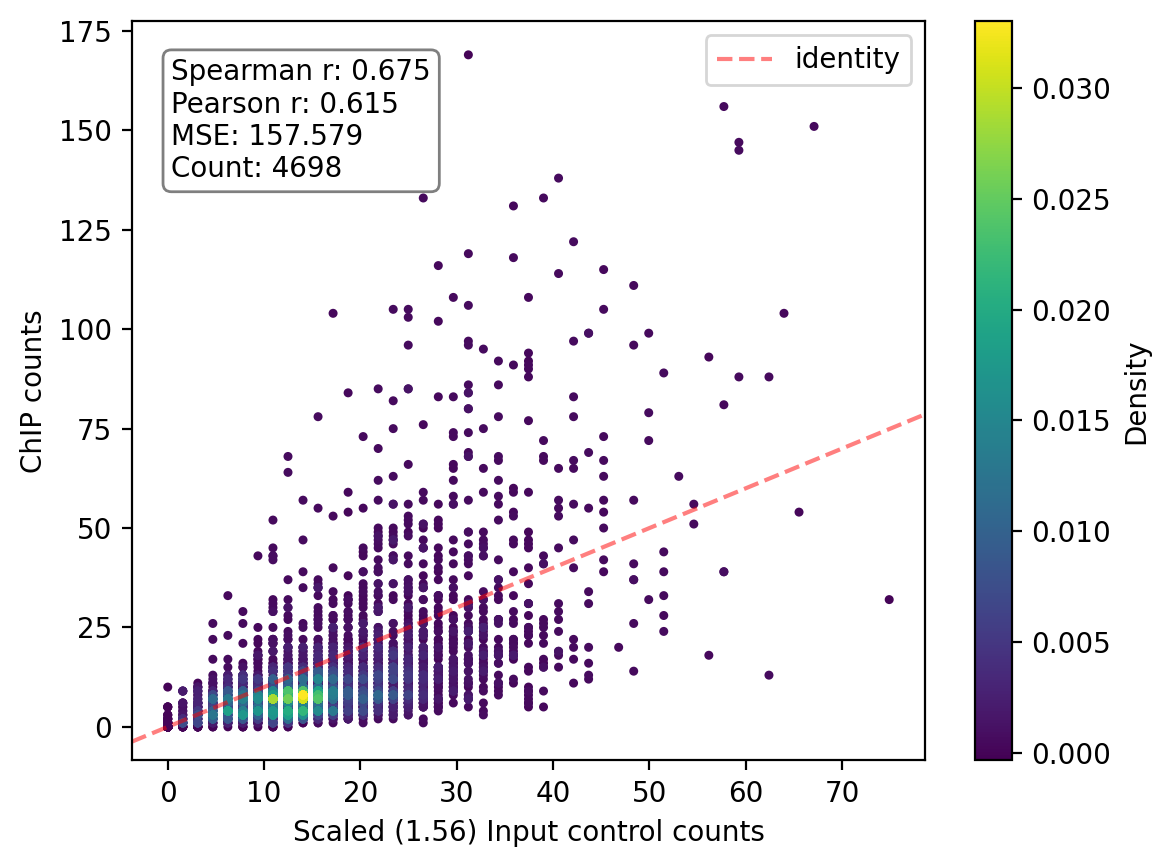

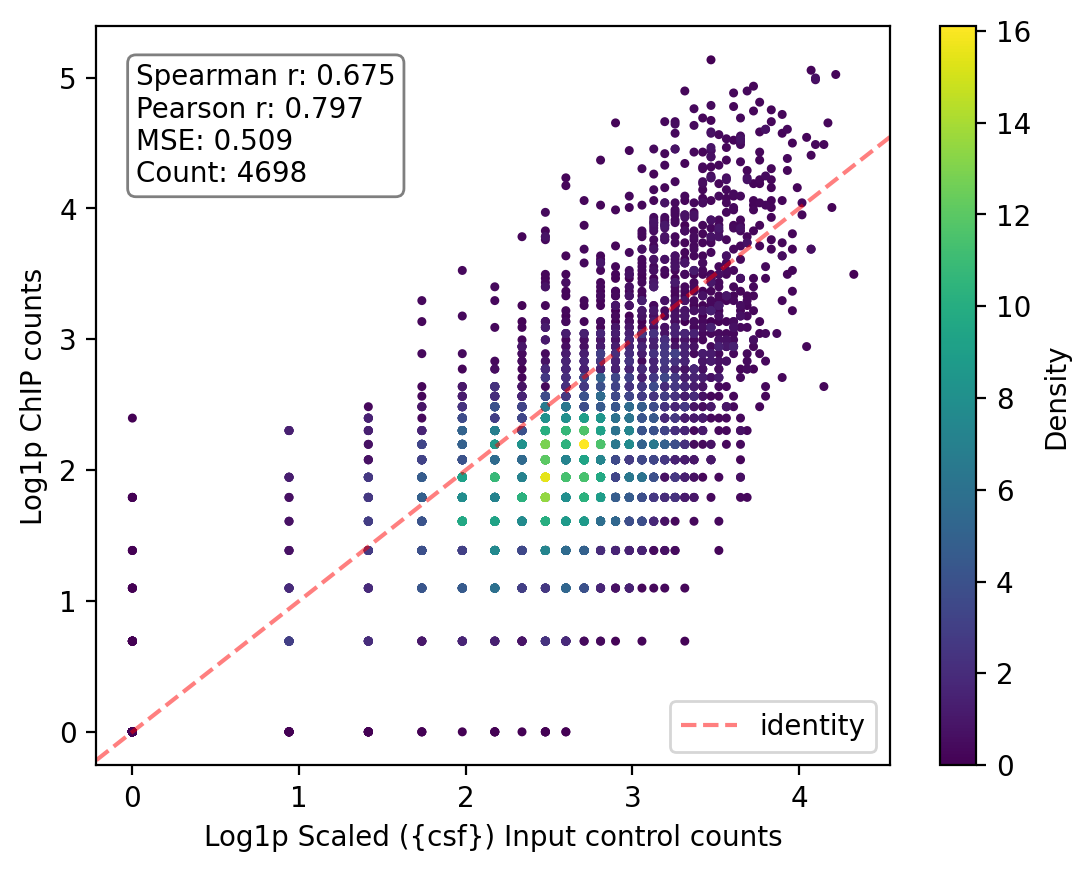

In [38]:
csf = 1.56
inputc_cts = get_cts(df_1kb, inputc_bw, None, get_total_cts=True, scaling_factor=csf)
inputc_cts = np.array([v[0] for v in inputc_cts]).squeeze()

# plot chip_cts vs inputc_cts
density_scatter(inputc_cts, chip_cts, f"Scaled ({csf}) Input control counts", "ChIP counts", s=5, bins=200, incl_stats=True) 
ax = plt.gca()
from toolbox.plt_utils import add_identity
add_identity(ax, color="r", ls="--", alpha=0.5)
plt.show()

# plot log chip_cts vs log inputc_cts
density_scatter(np.log1p(inputc_cts), np.log1p(chip_cts), "Log1p Scaled ({csf}) Input control counts", "Log1p ChIP counts", s=5, bins=200, incl_stats=True) 
ax = plt.gca()
from toolbox.plt_utils import add_identity
add_identity(ax, color="r", ls="--", alpha=0.5)
plt.show()

Indeed this matches: the "yellow" dots (high density) are below the y=x line, which matches what I see in the "test scatterplot" mentioned above (note that on that scatterplot y and x are reversed).

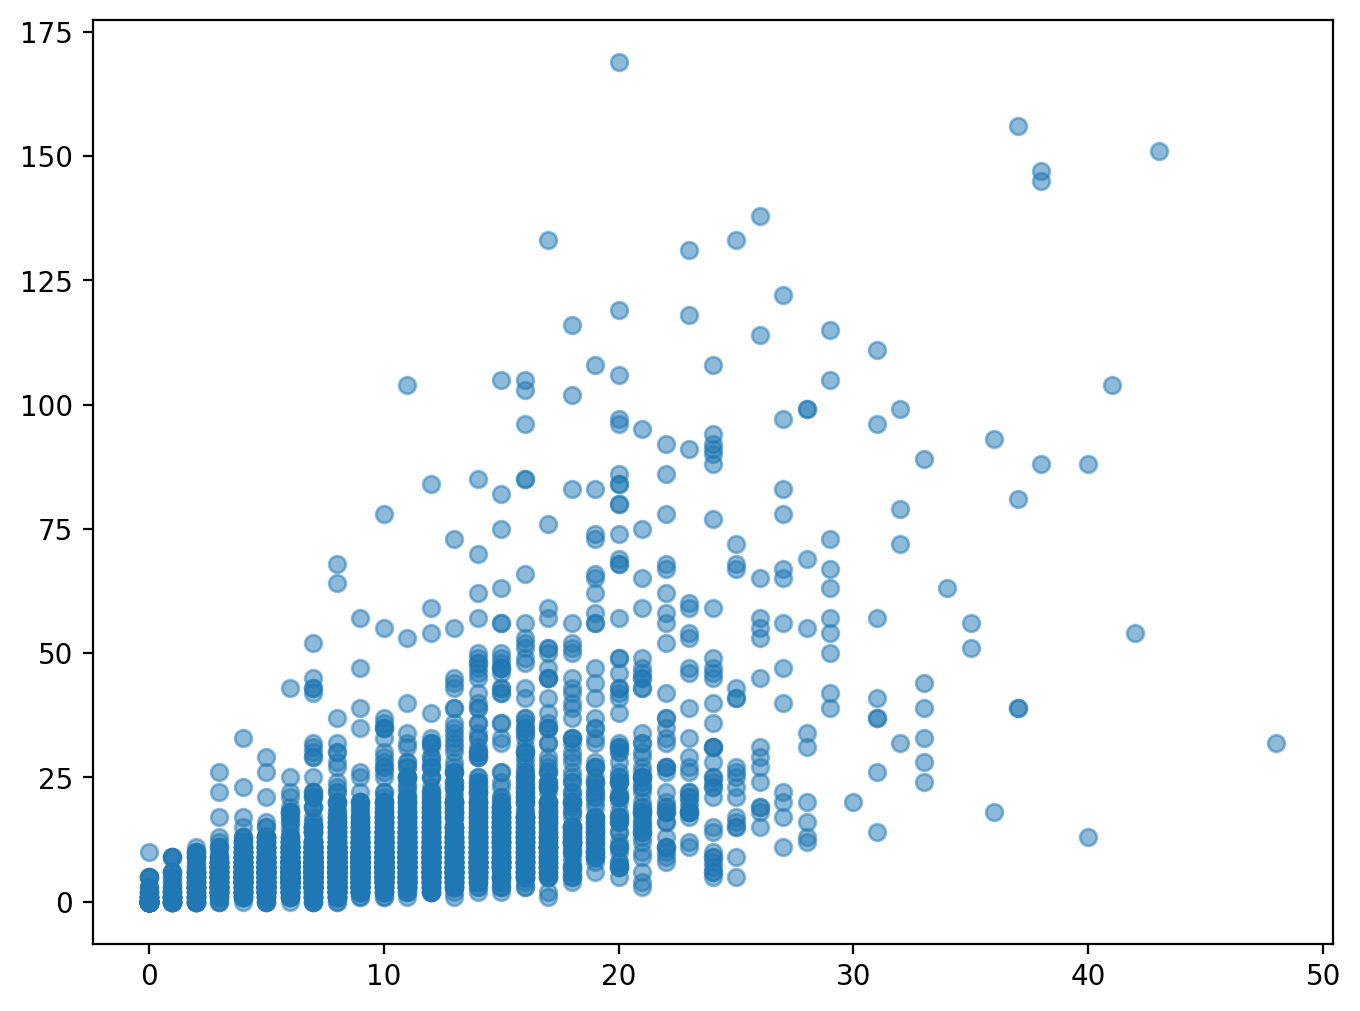

In [11]:
csf = 1.0
inputc_cts = get_cts(df_1kb, inputc_bw, None, get_total_cts=True, scaling_factor=csf)
inputc_cts = np.array([v[0] for v in inputc_cts]).squeeze()

plt.figure(figsize=(8, 6))
plt.scatter(inputc_cts, chip_cts, alpha=0.5)

^ I wanted to see if this looks exaclty like the plot in my notebook here (https://github.com/kundajelab/histobpnet/blob/main/experiments/valeh/notebooks/12_3_2025.ipynb) (the plot whose name I gave above). It is more "striped" than that plot... but I think it s probably becasue in that plot the rnage on the x axis is higher than here (whihc I explained earlier above).

One more thing Im confused above: on the plot above where I plot chip vs non-scaled control, I visually see a pretty good y=x relationship between the two (whcih is what we d expect biologically). However, there is like a "cloud" of loci where chip seems to be "far" higher than the diagonal y=x line. Why is that? Is that because of noise? Or is there some other explanation? I want to look up some of those loci in a brower. Maybe they "are" in high signal regiosn but not engouh to be called peaks.. I guess that s possible. 
Also, if you look at the 12_3_2025 notebook, you kind of consistnely see that "cloud" for various non-peak width configurations that I examined..

In [27]:
csf = 1.0
chip_cts = get_cts(df_1kb, chip_bw, None, get_total_cts=True)
inputc_cts = get_cts(df_1kb, inputc_bw, None, get_total_cts=True, scaling_factor=csf)

chip_cts = np.array([v[0] for v in chip_cts]).squeeze()
inputc_cts = np.array([v[0] for v in inputc_cts]).squeeze()

In [29]:
# visually determined by looking at the chip vs unscaled control plot
idx = np.where((chip_cts > 40) & (inputc_cts < 20))[0]
len(idx)

100

In [ ]:
df_1kb["peak_id"] = df_1kb["chrom"] + ":" + df_1kb["start"].astype(str) + "-" + df_1kb["end"].astype(str)
df_1kb["chip_cts_tmp"] = chip_cts
df_1kb.iloc[idx]

,chrom,start,end,3,4,5,peak_id,chip_cts_tmp
26,chr5,78923346,78924346,28,1000,-,chr5:78923346-78924346,51.0
144,chr8,745042,746042,152,1000,+,chr8:745042-746042,63.0
209,chr2,102237715,102238715,219,1000,+,chr2:102237715-102238715,53.0
212,chr15,90718637,90719637,222,1000,-,chr15:90718637-90719637,50.0
238,chr18,48851722,48852722,248,1000,-,chr18:48851722-48852722,49.0
...,...,...,...,...,...,...,...,...
4693,chr10,48692257,48693257,4935,1000,+,chr10:48692257-48693257,48.0
4706,chr19,7195372,7196372,4948,1000,+,chr19:7195372-7196372,58.0
4731,chr9,99174877,99175877,4973,1000,-,chr9:99174877-99175877,56.0
4778,chr17,231107,232107,5024,1000,-,chr17:231107-232107,45.0
